# import essential packages

In [20]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd
import matplotlib.animation as animation
from IPython.display import HTML
# from environment import *
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9118


In [21]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/WGAN_GP_experiment_exp_ln_3_down')

In [22]:
# Root directory for dataset
dataroot = "down_data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128
model_saving_interval = 1000
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64
G_saving_path = './model/gen/'
D_saving_path = './model/dis/'
# Number of training epochs
num_epochs = 100


# Learning rate for optimizers
lr = 0.000001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
#Grad Penalty 
LAMBDA = 5
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

-1

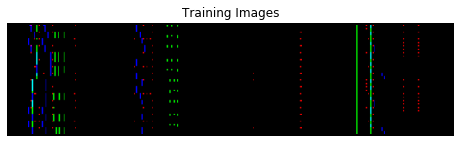

In [23]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
                               
#                            ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device =torch.device('cpu') 
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [24]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.preprocess = nn.Sequential(
            nn.Linear(nz,ngf*4*4*4*4),
            
#             nn.BatchNorm2d(ngf*64),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( ngf*16, ngf * 16, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 16),
#             nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.LayerNorm([ ngf * 8,8,8]),
#             nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([ ngf * 4,16,16]),
#             nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.LayerNorm([ ngf * 2,32,32]),
#             nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True), #layer norm 1 ori
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.LayerNorm([ ngf ,64,64]),
#             nn.BatchNorm2d(ngf),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
#             nn.Hardtanh(inplace = True)
#             nn.LeakyReLU(0.2, inplace=True)
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 16 * ngf, 4, 4)
#         print('gen output',output.shape)
        output = self.main(output)
        return output

In [26]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (preprocess): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LayerNorm((512, 8, 8), eps=1e-05, elementwise_affine=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LayerNorm((256, 16, 16), eps=1e-05, elementwise_affine=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=

In [27]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([ ndf * 4,16,16]),
#             nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LayerNorm([ ndf * 8,8,8]),
#             nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.LayerNorm([ ndf * 16,4,4]),
#             nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
#             nn.Flatten(-1),
            
#             nn.Linear(4*4*4*4*ndf,1)
#             nn.Sigmoid() # DCGAN
        )
        self.linear =nn.Linear(4*4*4*4*ndf,1)
    def forward(self, input):
        output = self.main(input)
#         print('dis output', output.shape)
        output = output.view(-1,4*4*4*4*ndf)
#         output = output.view(-1)
#         print('dis output after', output.shape)
        output = self.linear(output)
        return output

In [28]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LayerNorm((256, 16, 16), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): LayerNorm((512, 8, 8), eps=1e-05, elementwise_affine=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): LayerNorm((1024, 4, 4), eps=1e-05, elementwise_affine=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (linear): Linear(in_features=16384, out_

In [40]:
# Initialize BCELoss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_noise = torch.randn(64, nz, device=device)

num_epochs = 23000
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)
Dis_iter = 5
lr = 0.0003
# Establish convention for real and fake labels during training
real_label = 1
fake_label = -1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.9))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
# noise = torch.randn(b_size, nz, 1, 1, device=device)
G_cost = 0.0

for epoch in range(3000,num_epochs):
    ############################
    # (1) Update D network: 
    ###########################
    ## Train with all-real batch
    D_avg_cost = 0.0
    avg_GP = 0.0
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for Dis_iteration in range(Dis_iter):
        netD.zero_grad()
        _data = next(iter(dataloader))
        real_cpu = _data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        D_real = netD(real_cpu)
#         print('D_real shape',D_real.shape)
        D_real = D_real.mean(dim=0)
#         print('mean D_real shape',D_real.shape)
        D_real.backward(mone)
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz,  device=device)
        fake = netG(noise)
#         label.fill_(fake_label)
        D_fake = netD(fake.detach())
#         D_fake = netD(fake.detach()).view(-1)
#         print('D_fake shape',D_fake.shape)
        D_fake = D_fake.mean(dim = 0)
#         print('mean D_fake shape',D_fake.shape)
        D_fake.backward(one)
        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_cpu.data, fake.data)
        gradient_penalty.backward()
        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        D_avg_cost += D_cost
        avg_GP += gradient_penalty
        optimizerD.step()
    for tag, parm in netD.named_parameters():
        writer.add_histogram('Dis'+tag, parm.grad.data.cpu().numpy(), epoch)
    writer.add_scalar('DIS cost',D_avg_cost/Dis_iter ,epoch )
    writer.add_scalar('avg_GP',avg_GP/Dis_iter ,epoch )
    ############################
    # (2) Update G network
    ###########################
    
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()
    noise = torch.randn(b_size, nz,  device=device)
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         print('noise shape',noise.shape)
        # Generate fake image batch with G
    fake_G = netG(noise)
    label.fill_(fake_label)
#         print('fake',fake.shape)
        # Classify all fake batch with D
    G = netD(fake_G)
    G = G.mean(dim=0)
#     G = autograd.Variable(G,requires_grad = True)
    G.backward(mone)
    G_cost = -G
    optimizerG.step()
    for tag, parm in netG.named_parameters():
        writer.add_histogram('Gen'+tag, parm.grad.data.cpu().numpy(), epoch)
    
    writer.add_scalar('Gen cost',G_cost ,epoch )
    if epoch % model_saving_interval ==0:
        torch.save(netD.state_dict(), D_saving_path+'Dis_'+str(epoch)+'.pt')
        torch.save(netG.state_dict(), G_saving_path+'Gen_'+str(epoch)+'.pt')                     


        
    print('[%d/%d][%d/%d]\tD_cost: %.4f\tG_cost: %.4f\tD(real): %.4f\tD(G(z)): %.4f '
                  % (epoch, num_epochs, b_size, len(dataloader),
                     D_cost.item(), G_cost.item(), D_real, D_fake))
    if (epoch%500==0) or ((epoch == num_epochs-1) ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        
torch.save(netD.state_dict(), D_saving_path+'Dis_'+'backup'+'.pt')
torch.save(netG.state_dict(), G_saving_path+'Gen_'+'backup'+'.pt')

Starting Training Loop...
[3000/23000][64/1041]	D_cost: -15215.5996	G_cost: 8242.3555	D(real): -854.9832	D(G(z)): -17613.4492 
[3001/23000][64/1041]	D_cost: -21735.4395	G_cost: -4591.4429	D(real): 9214.3340	D(G(z)): -17956.3008 
[3002/23000][64/1041]	D_cost: -22476.4844	G_cost: 21957.4902	D(real): 19152.6445	D(G(z)): -5613.5010 
[3003/23000][64/1041]	D_cost: -19920.3203	G_cost: 21782.2715	D(real): 16880.4844	D(G(z)): -8134.0200 
[3004/23000][64/1041]	D_cost: -26299.1562	G_cost: 8978.3887	D(real): 7882.5186	D(G(z)): -20339.5859 
[3005/23000][64/1041]	D_cost: -29103.4004	G_cost: 20769.1328	D(real): 13249.7637	D(G(z)): -18599.1523 
[3006/23000][64/1041]	D_cost: -18579.7363	G_cost: 13254.5420	D(real): 10514.8027	D(G(z)): -11693.6328 
[3007/23000][64/1041]	D_cost: -22578.4043	G_cost: 21879.2422	D(real): 2813.9434	D(G(z)): -22095.8340 
[3008/23000][64/1041]	D_cost: -18624.0508	G_cost: 22120.5332	D(real): 16684.4355	D(G(z)): -4956.6592 
[3009/23000][64/1041]	D_cost: -31667.3613	G_cost: 17025.

[3080/23000][64/1041]	D_cost: -19873.5371	G_cost: 24184.1777	D(real): 2128.5273	D(G(z)): -24797.8281 
[3081/23000][64/1041]	D_cost: -25389.0977	G_cost: 23225.2617	D(real): 11836.3613	D(G(z)): -16148.1289 
[3082/23000][64/1041]	D_cost: -28160.4941	G_cost: 20892.0859	D(real): 10363.6182	D(G(z)): -23992.8438 
[3083/23000][64/1041]	D_cost: -30344.0469	G_cost: 24547.7793	D(real): 14871.3955	D(G(z)): -18851.9922 
[3084/23000][64/1041]	D_cost: -10879.4053	G_cost: 24701.5078	D(real): -5211.5430	D(G(z)): -25087.3555 
[3085/23000][64/1041]	D_cost: -30834.4766	G_cost: 21283.3105	D(real): 16882.9570	D(G(z)): -17128.7930 
[3086/23000][64/1041]	D_cost: -31959.3379	G_cost: 24395.9824	D(real): 20829.5781	D(G(z)): -15548.2598 
[3087/23000][64/1041]	D_cost: -28208.8008	G_cost: 21954.0098	D(real): 9562.4990	D(G(z)): -24546.6523 
[3088/23000][64/1041]	D_cost: -24127.0938	G_cost: 23911.8770	D(real): 22528.8672	D(G(z)): -13802.8340 
[3089/23000][64/1041]	D_cost: -29299.0469	G_cost: 11469.7168	D(real): 8396.

[3160/23000][64/1041]	D_cost: -25638.8730	G_cost: 27000.8750	D(real): 2424.5383	D(G(z)): -27375.6543 
[3161/23000][64/1041]	D_cost: -22811.8496	G_cost: 24692.3145	D(real): -594.2440	D(G(z)): -27536.8711 
[3162/23000][64/1041]	D_cost: -30960.4727	G_cost: 20764.3828	D(real): 15182.2080	D(G(z)): -17708.4199 
[3163/23000][64/1041]	D_cost: -26725.8789	G_cost: 26279.9258	D(real): 21450.3945	D(G(z)): -9507.8447 
[3164/23000][64/1041]	D_cost: -33938.1680	G_cost: 16564.5039	D(real): 14720.8662	D(G(z)): -23970.4609 
[3165/23000][64/1041]	D_cost: -30202.2539	G_cost: 21568.5000	D(real): 11230.5322	D(G(z)): -23805.8164 
[3166/23000][64/1041]	D_cost: -30657.9707	G_cost: 19489.8203	D(real): 8560.0254	D(G(z)): -24661.4219 
[3167/23000][64/1041]	D_cost: -27525.9277	G_cost: 18286.0430	D(real): 4073.1558	D(G(z)): -26796.9219 
[3168/23000][64/1041]	D_cost: -31223.5020	G_cost: 10912.9541	D(real): 7421.3301	D(G(z)): -26379.7207 
[3169/23000][64/1041]	D_cost: -19287.3262	G_cost: 8059.7720	D(real): 33.3469	D(

[3241/23000][64/1041]	D_cost: -36100.7891	G_cost: 28791.5703	D(real): 7730.2759	D(G(z)): -31423.3281 
[3242/23000][64/1041]	D_cost: -39737.9180	G_cost: 30884.9570	D(real): 22402.5586	D(G(z)): -21638.5977 
[3243/23000][64/1041]	D_cost: -29606.2578	G_cost: 28664.1055	D(real): 2408.3206	D(G(z)): -30889.6660 
[3244/23000][64/1041]	D_cost: -38256.2031	G_cost: 19318.0430	D(real): 13262.9648	D(G(z)): -27976.2246 
[3245/23000][64/1041]	D_cost: -36120.4805	G_cost: 31106.1328	D(real): 20512.2832	D(G(z)): -19100.2578 
[3246/23000][64/1041]	D_cost: -43872.6641	G_cost: 27791.3945	D(real): 17789.8945	D(G(z)): -29279.9473 
[3247/23000][64/1041]	D_cost: -31325.4023	G_cost: 31501.6289	D(real): 4535.6763	D(G(z)): -31739.1016 
[3248/23000][64/1041]	D_cost: -42487.4961	G_cost: 30591.8594	D(real): 20488.9453	D(G(z)): -25953.8691 
[3249/23000][64/1041]	D_cost: -39497.0859	G_cost: 9480.3486	D(real): 13823.4932	D(G(z)): -28541.0312 
[3250/23000][64/1041]	D_cost: -34396.9531	G_cost: 30336.6016	D(real): 15110.4

[3321/23000][64/1041]	D_cost: -47242.6953	G_cost: 35133.6523	D(real): 24090.2539	D(G(z)): -26742.5938 
[3322/23000][64/1041]	D_cost: -36574.0312	G_cost: 34528.8320	D(real): 5559.4688	D(G(z)): -34746.3906 
[3323/23000][64/1041]	D_cost: -58672.5352	G_cost: 34798.2109	D(real): 30003.5020	D(G(z)): -33082.3906 
[3324/23000][64/1041]	D_cost: -41620.0273	G_cost: 34754.0469	D(real): 10424.3301	D(G(z)): -35345.6875 
[3325/23000][64/1041]	D_cost: -52007.2188	G_cost: 35242.5312	D(real): 31447.4434	D(G(z)): -24536.5742 
[3326/23000][64/1041]	D_cost: -51438.7539	G_cost: 34839.4375	D(real): 20704.2246	D(G(z)): -35151.9219 
[3327/23000][64/1041]	D_cost: -48252.3945	G_cost: 35251.6875	D(real): 32389.6953	D(G(z)): -20476.3477 
[3328/23000][64/1041]	D_cost: -45183.0781	G_cost: 35298.7578	D(real): 13513.8535	D(G(z)): -35253.9141 
[3329/23000][64/1041]	D_cost: -56357.1016	G_cost: 32864.4922	D(real): 28348.2266	D(G(z)): -31505.8457 
[3330/23000][64/1041]	D_cost: -36408.9531	G_cost: 34997.8984	D(real): 9436

[3401/23000][64/1041]	D_cost: -54992.8203	G_cost: 39068.5547	D(real): 31068.1250	D(G(z)): -30596.2578 
[3402/23000][64/1041]	D_cost: -53285.9922	G_cost: 22789.3242	D(real): 19867.5117	D(G(z)): -37640.6602 
[3403/23000][64/1041]	D_cost: -53872.1992	G_cost: 38824.9219	D(real): 30617.5078	D(G(z)): -28403.9668 
[3404/23000][64/1041]	D_cost: -55695.1875	G_cost: 37047.4766	D(real): 26499.5312	D(G(z)): -33969.0078 
[3405/23000][64/1041]	D_cost: -47099.6328	G_cost: 34434.3750	D(real): 12642.1016	D(G(z)): -38567.5859 
[3406/23000][64/1041]	D_cost: -60179.3242	G_cost: 28735.7148	D(real): 28614.9062	D(G(z)): -36419.8984 
[3407/23000][64/1041]	D_cost: -39371.4102	G_cost: 37755.1523	D(real): 21190.6094	D(G(z)): -21853.9297 
[3408/23000][64/1041]	D_cost: -35211.2773	G_cost: 32856.1133	D(real): 17896.5977	D(G(z)): -20720.3711 
[3409/23000][64/1041]	D_cost: -31272.3125	G_cost: 29658.2500	D(real): 7574.4712	D(G(z)): -28101.7070 
[3410/23000][64/1041]	D_cost: -24620.7188	G_cost: 38292.6953	D(real): -955

[3481/23000][64/1041]	D_cost: -36268.3203	G_cost: 41656.4258	D(real): -3701.0017	D(G(z)): -43005.5430 
[3482/23000][64/1041]	D_cost: -50711.7969	G_cost: 33489.1406	D(real): 22990.1250	D(G(z)): -31950.7500 
[3483/23000][64/1041]	D_cost: -37100.8828	G_cost: 41343.0586	D(real): 6626.9541	D(G(z)): -43140.3359 
[3484/23000][64/1041]	D_cost: -54528.1328	G_cost: 27492.0156	D(real): 26026.1953	D(G(z)): -34634.8672 
[3485/23000][64/1041]	D_cost: -47058.7930	G_cost: 17093.9004	D(real): 11313.1367	D(G(z)): -40668.6719 
[3486/23000][64/1041]	D_cost: -50118.8398	G_cost: 31582.9551	D(real): 18373.0664	D(G(z)): -35992.9609 
[3487/23000][64/1041]	D_cost: -35907.1797	G_cost: 37654.1680	D(real): 3595.6406	D(G(z)): -39390.9375 
[3488/23000][64/1041]	D_cost: -44069.0234	G_cost: 32217.9688	D(real): 8845.9492	D(G(z)): -40600.1445 
[3489/23000][64/1041]	D_cost: -27574.8008	G_cost: 34349.5547	D(real): 9320.8525	D(G(z)): -22031.8867 
[3490/23000][64/1041]	D_cost: -25313.3789	G_cost: 39685.2500	D(real): 19246.6

[3561/23000][64/1041]	D_cost: -78251.3984	G_cost: 40472.7109	D(real): 43482.9062	D(G(z)): -43360.9453 
[3562/23000][64/1041]	D_cost: -60430.6094	G_cost: 42870.8672	D(real): 25646.5684	D(G(z)): -37745.6250 
[3563/23000][64/1041]	D_cost: -62501.7617	G_cost: 47106.3984	D(real): 43312.8203	D(G(z)): -25945.7578 
[3564/23000][64/1041]	D_cost: -52104.0234	G_cost: 27847.7051	D(real): 10674.3672	D(G(z)): -44973.1445 
[3565/23000][64/1041]	D_cost: -57062.6953	G_cost: 38266.2461	D(real): 17457.7031	D(G(z)): -44905.8438 
[3566/23000][64/1041]	D_cost: -50572.4453	G_cost: 36908.8672	D(real): 12017.1719	D(G(z)): -44120.7500 
[3567/23000][64/1041]	D_cost: -57933.9062	G_cost: 41541.8555	D(real): 21065.2461	D(G(z)): -44104.1172 
[3568/23000][64/1041]	D_cost: -51755.4922	G_cost: 30367.5078	D(real): 21814.2617	D(G(z)): -34407.8398 
[3569/23000][64/1041]	D_cost: -48714.9297	G_cost: 31168.5527	D(real): 24976.8984	D(G(z)): -28689.1934 
[3570/23000][64/1041]	D_cost: -43283.3281	G_cost: 28806.1367	D(real): 963

Traceback (most recent call last):
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-mcovpq_8'


[3595/23000][64/1041]	D_cost: -52107.8633	G_cost: 44957.7891	D(real): 23976.7383	D(G(z)): -32113.4707 
[3596/23000][64/1041]	D_cost: -63174.1641	G_cost: 41558.3398	D(real): 27679.8848	D(G(z)): -41543.6172 
[3597/23000][64/1041]	D_cost: -60152.1289	G_cost: 37789.5664	D(real): 31435.5312	D(G(z)): -43514.9648 
[3598/23000][64/1041]	D_cost: -66909.3281	G_cost: 48662.0352	D(real): 33874.5078	D(G(z)): -39785.6016 
[3599/23000][64/1041]	D_cost: -56101.5586	G_cost: 50012.5469	D(real): 36436.1836	D(G(z)): -26726.8008 
[3600/23000][64/1041]	D_cost: -60646.9453	G_cost: 30078.0684	D(real): 27966.7012	D(G(z)): -47354.4297 
[3601/23000][64/1041]	D_cost: -57088.1172	G_cost: 39487.6211	D(real): 13677.8555	D(G(z)): -48014.0625 
[3602/23000][64/1041]	D_cost: -61792.5117	G_cost: 48798.7109	D(real): 37208.5547	D(G(z)): -29734.8945 
[3603/23000][64/1041]	D_cost: -58644.7383	G_cost: 26524.5352	D(real): 19190.5977	D(G(z)): -47734.5195 
[3604/23000][64/1041]	D_cost: -44927.9805	G_cost: 37290.2734	D(real): 249

[3675/23000][64/1041]	D_cost: -60939.6523	G_cost: 28712.4473	D(real): 19010.7402	D(G(z)): -47936.9141 
[3676/23000][64/1041]	D_cost: -60549.2031	G_cost: 44433.4531	D(real): 24486.6875	D(G(z)): -40628.1562 
[3677/23000][64/1041]	D_cost: -62572.3125	G_cost: 51063.5234	D(real): 35885.5352	D(G(z)): -31847.8789 
[3678/23000][64/1041]	D_cost: -38130.3711	G_cost: 54764.8906	D(real): -5827.4087	D(G(z)): -54687.9531 
[3679/23000][64/1041]	D_cost: -72220.4141	G_cost: 33789.2812	D(real): 27874.3281	D(G(z)): -50379.9219 
[3680/23000][64/1041]	D_cost: -70111.2891	G_cost: 49136.3906	D(real): 29180.5586	D(G(z)): -50114.8516 
[3681/23000][64/1041]	D_cost: -56388.8984	G_cost: 46098.8438	D(real): 23521.9844	D(G(z)): -54530.3047 
[3682/23000][64/1041]	D_cost: -64661.8125	G_cost: 41901.3828	D(real): 22960.9082	D(G(z)): -48892.4023 
[3683/23000][64/1041]	D_cost: -59352.3594	G_cost: 52768.7266	D(real): 12673.1035	D(G(z)): -53870.8008 
[3684/23000][64/1041]	D_cost: -64808.0703	G_cost: 34192.5547	D(real): 207

[3755/23000][64/1041]	D_cost: -77408.4766	G_cost: 46555.4375	D(real): 33530.9688	D(G(z)): -50979.9922 
[3756/23000][64/1041]	D_cost: -56568.8867	G_cost: 51789.9805	D(real): 18602.7266	D(G(z)): -47303.4727 
[3757/23000][64/1041]	D_cost: -55033.9609	G_cost: 59207.0430	D(real): 40521.3750	D(G(z)): -22774.5508 
[3758/23000][64/1041]	D_cost: -63645.4922	G_cost: 56529.8125	D(real): 25926.7246	D(G(z)): -42213.6797 
[3759/23000][64/1041]	D_cost: -57388.7461	G_cost: 58013.3750	D(real): 27375.1914	D(G(z)): -39761.1680 
[3760/23000][64/1041]	D_cost: -67127.2812	G_cost: 40815.8203	D(real): 20617.2344	D(G(z)): -53089.3672 
[3761/23000][64/1041]	D_cost: -64843.3594	G_cost: 55257.8398	D(real): 33503.3906	D(G(z)): -37855.5938 
[3762/23000][64/1041]	D_cost: -61452.7539	G_cost: 34388.9336	D(real): 15285.4043	D(G(z)): -54586.6445 
[3763/23000][64/1041]	D_cost: -59477.0625	G_cost: 44002.8984	D(real): 26607.3164	D(G(z)): -37686.4844 
[3764/23000][64/1041]	D_cost: -58668.7773	G_cost: 39272.3164	D(real): 106

[3835/23000][64/1041]	D_cost: -81463.0156	G_cost: 54483.0469	D(real): 31165.0098	D(G(z)): -58897.3047 
[3836/23000][64/1041]	D_cost: -62732.0391	G_cost: 54016.6562	D(real): 35187.8750	D(G(z)): -56485.9531 
[3837/23000][64/1041]	D_cost: -67512.4922	G_cost: 55113.9141	D(real): 13512.2490	D(G(z)): -61095.8789 
[3838/23000][64/1041]	D_cost: -41854.5352	G_cost: 37750.8945	D(real): 6902.2920	D(G(z)): -60281.3672 
[3839/23000][64/1041]	D_cost: -60134.3438	G_cost: 48361.0234	D(real): 12912.3184	D(G(z)): -53018.7539 
[3840/23000][64/1041]	D_cost: -64760.3906	G_cost: 55436.2266	D(real): 15087.4551	D(G(z)): -57742.0039 
[3841/23000][64/1041]	D_cost: -56527.1953	G_cost: 51968.7188	D(real): 8005.7432	D(G(z)): -55637.8672 
[3842/23000][64/1041]	D_cost: -47431.0117	G_cost: 39245.7031	D(real): -3218.5952	D(G(z)): -57392.9766 
[3843/23000][64/1041]	D_cost: -67317.6641	G_cost: 49741.3047	D(real): 27121.3496	D(G(z)): -45585.3906 
[3844/23000][64/1041]	D_cost: -70666.7031	G_cost: 55288.4180	D(real): 23506

[3915/23000][64/1041]	D_cost: -69299.6719	G_cost: 68716.9844	D(real): 35185.1562	D(G(z)): -40763.8984 
[3916/23000][64/1041]	D_cost: -89313.0000	G_cost: 69894.1250	D(real): 51380.6172	D(G(z)): -47669.2578 
[3917/23000][64/1041]	D_cost: -65683.9375	G_cost: 60902.1797	D(real): 3431.6025	D(G(z)): -70582.7812 
[3918/23000][64/1041]	D_cost: -91028.9375	G_cost: 69437.3438	D(real): 58644.7383	D(G(z)): -43137.9961 
[3919/23000][64/1041]	D_cost: -95724.2188	G_cost: 67738.4531	D(real): 51445.9844	D(G(z)): -51926.5156 
[3920/23000][64/1041]	D_cost: -92425.2656	G_cost: 69646.6484	D(real): 53753.2734	D(G(z)): -49734.2891 
[3921/23000][64/1041]	D_cost: -99281.6953	G_cost: 70166.5938	D(real): 55219.1094	D(G(z)): -53667.7852 
[3922/23000][64/1041]	D_cost: -73250.6328	G_cost: 65807.0625	D(real): 10158.7910	D(G(z)): -71203.1797 
[3923/23000][64/1041]	D_cost: -93074.5781	G_cost: 69813.8438	D(real): 56143.6328	D(G(z)): -51513.7031 
[3924/23000][64/1041]	D_cost: -89812.0938	G_cost: 62687.8008	D(real): 3959

[3995/23000][64/1041]	D_cost: -87768.9453	G_cost: 64021.4102	D(real): 32005.9961	D(G(z)): -65577.9922 
[3996/23000][64/1041]	D_cost: -85352.6016	G_cost: 64149.4297	D(real): 25426.0469	D(G(z)): -72648.2031 
[3997/23000][64/1041]	D_cost: -75099.9609	G_cost: 58069.3750	D(real): 16350.8760	D(G(z)): -69950.4062 
[3998/23000][64/1041]	D_cost: -84826.2031	G_cost: 53158.6758	D(real): 31303.4219	D(G(z)): -63796.9375 
[3999/23000][64/1041]	D_cost: -83947.6094	G_cost: 67851.7344	D(real): 27342.6562	D(G(z)): -66028.8359 
[4000/23000][64/1041]	D_cost: -82558.2969	G_cost: 75629.7812	D(real): 42981.9141	D(G(z)): -49343.0859 
[4001/23000][64/1041]	D_cost: -45199.1484	G_cost: 71996.7188	D(real): -15320.0430	D(G(z)): -76116.6719 
[4002/23000][64/1041]	D_cost: -85402.5000	G_cost: 66453.4375	D(real): 23470.2656	D(G(z)): -74814.2344 
[4003/23000][64/1041]	D_cost: -72898.0156	G_cost: 59926.8438	D(real): 13702.2871	D(G(z)): -71352.8828 
[4004/23000][64/1041]	D_cost: -72354.9141	G_cost: 52731.6797	D(real): 20

[4075/23000][64/1041]	D_cost: -89799.8594	G_cost: 66225.5703	D(real): 49629.4062	D(G(z)): -65681.0000 
[4076/23000][64/1041]	D_cost: -71066.7188	G_cost: 52260.6328	D(real): 7263.3496	D(G(z)): -78017.5938 
[4077/23000][64/1041]	D_cost: -95638.3828	G_cost: 76399.8516	D(real): 44511.6914	D(G(z)): -58385.0117 
[4078/23000][64/1041]	D_cost: -74172.2031	G_cost: 49404.4688	D(real): 15607.2021	D(G(z)): -68841.7109 
[4079/23000][64/1041]	D_cost: -73007.3281	G_cost: 67189.9688	D(real): 37216.1797	D(G(z)): -43208.0039 
[4080/23000][64/1041]	D_cost: -81292.2969	G_cost: 57707.9688	D(real): 27695.2363	D(G(z)): -62686.9219 
[4081/23000][64/1041]	D_cost: -92720.3672	G_cost: 78216.6094	D(real): 53069.9297	D(G(z)): -48636.4961 
[4082/23000][64/1041]	D_cost: -90188.4062	G_cost: 77986.8750	D(real): 64910.8906	D(G(z)): -43898.1875 
[4083/23000][64/1041]	D_cost: -103560.6719	G_cost: 71560.6719	D(real): 60833.2773	D(G(z)): -61210.8164 
[4084/23000][64/1041]	D_cost: -98340.7656	G_cost: 54539.9062	D(real): 444

[4155/23000][64/1041]	D_cost: -110376.1562	G_cost: 78211.3281	D(real): 48872.3750	D(G(z)): -69200.1250 
[4156/23000][64/1041]	D_cost: -53879.7656	G_cost: 77844.1172	D(real): -9106.1445	D(G(z)): -87345.7344 
[4157/23000][64/1041]	D_cost: -94888.9375	G_cost: 56334.7109	D(real): 33395.3320	D(G(z)): -68727.1953 
[4158/23000][64/1041]	D_cost: -99819.2969	G_cost: 44864.2422	D(real): 44447.1914	D(G(z)): -66899.5234 
[4159/23000][64/1041]	D_cost: -76928.7344	G_cost: 45295.3828	D(real): 33916.4922	D(G(z)): -56112.5820 
[4160/23000][64/1041]	D_cost: -51437.0625	G_cost: 33417.4375	D(real): 47832.8477	D(G(z)): -13030.3398 
[4161/23000][64/1041]	D_cost: -71670.3594	G_cost: 71436.0781	D(real): 24941.1094	D(G(z)): -52975.9922 
[4162/23000][64/1041]	D_cost: -73045.1172	G_cost: 77186.4375	D(real): 4785.0420	D(G(z)): -79781.6094 
[4163/23000][64/1041]	D_cost: -97775.7969	G_cost: 51448.4844	D(real): 31476.8750	D(G(z)): -77381.2422 
[4164/23000][64/1041]	D_cost: -69493.5781	G_cost: 69860.6406	D(real): 600

[4235/23000][64/1041]	D_cost: -104947.0859	G_cost: 85009.7969	D(real): 65539.7344	D(G(z)): -62647.3828 
[4236/23000][64/1041]	D_cost: -116518.8750	G_cost: 76544.2969	D(real): 42204.9844	D(G(z)): -86613.4531 
[4237/23000][64/1041]	D_cost: -113971.2344	G_cost: 48988.8633	D(real): 39847.6953	D(G(z)): -90231.6406 
[4238/23000][64/1041]	D_cost: -109098.2891	G_cost: 86102.3984	D(real): 54299.2500	D(G(z)): -65953.1406 
[4239/23000][64/1041]	D_cost: -107004.0703	G_cost: 25501.7070	D(real): 37738.2031	D(G(z)): -86598.7188 
[4240/23000][64/1041]	D_cost: -108639.4531	G_cost: 83872.6250	D(real): 48197.0664	D(G(z)): -70613.4688 
[4241/23000][64/1041]	D_cost: -83248.4688	G_cost: 28013.2266	D(real): 30231.6094	D(G(z)): -78585.6953 
[4242/23000][64/1041]	D_cost: -91701.9062	G_cost: 78850.0781	D(real): 36941.8125	D(G(z)): -67497.9609 
[4243/23000][64/1041]	D_cost: -88961.7109	G_cost: 87169.4062	D(real): 55246.5508	D(G(z)): -48878.1094 
[4244/23000][64/1041]	D_cost: -101978.4062	G_cost: 67310.1719	D(rea

[4314/23000][64/1041]	D_cost: -131013.1797	G_cost: 96268.2109	D(real): 66174.3984	D(G(z)): -79379.2031 
[4315/23000][64/1041]	D_cost: -122286.3281	G_cost: 86381.7891	D(real): 68589.2188	D(G(z)): -64273.3672 
[4316/23000][64/1041]	D_cost: -128937.8672	G_cost: 87177.6719	D(real): 52067.8125	D(G(z)): -92429.0078 
[4317/23000][64/1041]	D_cost: -126986.0391	G_cost: 77274.2812	D(real): 48166.7734	D(G(z)): -89604.7188 
[4318/23000][64/1041]	D_cost: -102939.5156	G_cost: 90435.8906	D(real): 49473.4844	D(G(z)): -65681.5000 
[4319/23000][64/1041]	D_cost: -108969.1641	G_cost: 89613.9219	D(real): 54094.2617	D(G(z)): -65366.3281 
[4320/23000][64/1041]	D_cost: -111095.5312	G_cost: 60279.1641	D(real): 52517.6484	D(G(z)): -88136.3281 
[4321/23000][64/1041]	D_cost: -109720.5078	G_cost: 73068.6875	D(real): 42045.0977	D(G(z)): -78861.0469 
[4322/23000][64/1041]	D_cost: -64835.1562	G_cost: 66114.7656	D(real): 7560.8418	D(G(z)): -73470.5156 
[4323/23000][64/1041]	D_cost: -48941.8438	G_cost: -15689.1328	D(re

[4393/23000][64/1041]	D_cost: -148718.7344	G_cost: 81551.5312	D(real): 67478.4062	D(G(z)): -98318.9688 
[4394/23000][64/1041]	D_cost: -157616.7031	G_cost: 96272.0469	D(real): 78533.0469	D(G(z)): -96397.4844 
[4395/23000][64/1041]	D_cost: -159659.5469	G_cost: 79936.7578	D(real): 78348.1094	D(G(z)): -96613.5938 
[4396/23000][64/1041]	D_cost: -135028.2344	G_cost: 105523.8594	D(real): 56724.8047	D(G(z)): -99623.2031 
[4397/23000][64/1041]	D_cost: -155564.7656	G_cost: 100670.3125	D(real): 73790.7500	D(G(z)): -92185.9609 
[4398/23000][64/1041]	D_cost: -136934.6250	G_cost: 73830.0156	D(real): 52006.5938	D(G(z)): -104964.0312 
[4399/23000][64/1041]	D_cost: -152202.6719	G_cost: 83817.3750	D(real): 68287.3203	D(G(z)): -97802.2422 
[4400/23000][64/1041]	D_cost: -122372.1875	G_cost: 82838.8125	D(real): 35041.6094	D(G(z)): -103325.4219 
[4401/23000][64/1041]	D_cost: -146860.7812	G_cost: 98011.7109	D(real): 64491.1562	D(G(z)): -94569.1250 
[4402/23000][64/1041]	D_cost: -130553.9531	G_cost: 85232.218

[4472/23000][64/1041]	D_cost: -160093.7812	G_cost: 109490.6875	D(real): 78301.1094	D(G(z)): -97292.7656 
[4473/23000][64/1041]	D_cost: -127554.8203	G_cost: 115007.6641	D(real): 89566.5625	D(G(z)): -58198.9492 
[4474/23000][64/1041]	D_cost: -141860.2500	G_cost: 97061.5469	D(real): 43386.1406	D(G(z)): -110795.5547 
[4475/23000][64/1041]	D_cost: -149216.0938	G_cost: 115059.8125	D(real): 92497.4062	D(G(z)): -71944.0469 
[4476/23000][64/1041]	D_cost: -121384.8438	G_cost: 68067.2031	D(real): 26637.1953	D(G(z)): -108802.1406 
[4477/23000][64/1041]	D_cost: -140992.6719	G_cost: 100624.5312	D(real): 68719.4375	D(G(z)): -86504.3438 
[4478/23000][64/1041]	D_cost: -122252.9219	G_cost: 110676.3438	D(real): 71531.2266	D(G(z)): -62434.5000 
[4479/23000][64/1041]	D_cost: -142829.9219	G_cost: 89975.4062	D(real): 72770.3047	D(G(z)): -84076.7969 
[4480/23000][64/1041]	D_cost: -109949.7812	G_cost: 101089.9688	D(real): 36911.2852	D(G(z)): -85858.0469 
[4481/23000][64/1041]	D_cost: -128848.3984	G_cost: 67938

[4551/23000][64/1041]	D_cost: -127043.1172	G_cost: 105592.0938	D(real): 57016.6758	D(G(z)): -79681.1250 
[4552/23000][64/1041]	D_cost: -129716.3672	G_cost: 121664.7500	D(real): 69343.0469	D(G(z)): -78202.5781 
[4553/23000][64/1041]	D_cost: -142735.0312	G_cost: 94732.5312	D(real): 43722.7148	D(G(z)): -116511.8906 
[4554/23000][64/1041]	D_cost: -142482.3125	G_cost: 95019.0938	D(real): 60711.6172	D(G(z)): -95130.1797 
[4555/23000][64/1041]	D_cost: -112322.5156	G_cost: 102460.4844	D(real): 11836.8623	D(G(z)): -119604.0234 
[4556/23000][64/1041]	D_cost: -160047.4688	G_cost: 117388.4375	D(real): 83470.0000	D(G(z)): -91832.3750 
[4557/23000][64/1041]	D_cost: -159089.7500	G_cost: 119291.2188	D(real): 98364.3281	D(G(z)): -80221.3047 
[4558/23000][64/1041]	D_cost: -159110.7344	G_cost: 95956.9297	D(real): 86141.6953	D(G(z)): -96573.9922 
[4559/23000][64/1041]	D_cost: -155964.8125	G_cost: 110704.5000	D(real): 82012.3906	D(G(z)): -90256.1562 
[4560/23000][64/1041]	D_cost: -152284.3438	G_cost: 66712

[4629/23000][64/1041]	D_cost: -163646.2500	G_cost: 127182.9453	D(real): 112069.1719	D(G(z)): -91634.6641 
[4630/23000][64/1041]	D_cost: -156783.3125	G_cost: 95516.4766	D(real): 71413.6250	D(G(z)): -100503.2188 
[4631/23000][64/1041]	D_cost: -131723.4219	G_cost: 125313.0625	D(real): 24084.2461	D(G(z)): -128904.0312 
[4632/23000][64/1041]	D_cost: -191994.4219	G_cost: 120375.7188	D(real): 95533.2031	D(G(z)): -110373.2969 
[4633/23000][64/1041]	D_cost: -150653.7188	G_cost: 128575.9375	D(real): 77337.0859	D(G(z)): -87410.0859 
[4634/23000][64/1041]	D_cost: -188449.6094	G_cost: 99427.6719	D(real): 92003.6328	D(G(z)): -115430.3438 
[4635/23000][64/1041]	D_cost: -139292.8438	G_cost: 113851.4375	D(real): 69424.2734	D(G(z)): -85522.6719 
[4636/23000][64/1041]	D_cost: -153633.4844	G_cost: 119166.2188	D(real): 70612.5000	D(G(z)): -94437.5312 
[4637/23000][64/1041]	D_cost: -173742.3281	G_cost: 101466.1094	D(real): 100434.3203	D(G(z)): -90309.7188 
[4638/23000][64/1041]	D_cost: -175738.7188	G_cost: 

[4707/23000][64/1041]	D_cost: -151244.5312	G_cost: 67865.3438	D(real): 56003.1641	D(G(z)): -122008.9219 
[4708/23000][64/1041]	D_cost: -123792.0469	G_cost: 111892.5781	D(real): 52759.4805	D(G(z)): -79150.3750 
[4709/23000][64/1041]	D_cost: -21451.7324	G_cost: -15987.6377	D(real): 145259.5781	D(G(z)): 94684.5938 
[4710/23000][64/1041]	D_cost: -142439.9688	G_cost: 115708.6875	D(real): 53913.2266	D(G(z)): -97642.5781 
[4711/23000][64/1041]	D_cost: -146986.0469	G_cost: 99289.9219	D(real): 51316.8242	D(G(z)): -114032.9375 
[4712/23000][64/1041]	D_cost: -152626.5938	G_cost: 119274.7344	D(real): 59978.1328	D(G(z)): -108329.6719 
[4713/23000][64/1041]	D_cost: -141978.4219	G_cost: 77010.0781	D(real): 36995.9492	D(G(z)): -128510.8906 
[4714/23000][64/1041]	D_cost: -152559.0469	G_cost: 64621.9141	D(real): 45255.8984	D(G(z)): -124260.5859 
[4715/23000][64/1041]	D_cost: -169837.6406	G_cost: 123922.2266	D(real): 64050.4766	D(G(z)): -122800.8047 
[4716/23000][64/1041]	D_cost: -180662.9219	G_cost: 139

[4785/23000][64/1041]	D_cost: -177774.0000	G_cost: 132592.8750	D(real): 87250.0000	D(G(z)): -112623.0938 
[4786/23000][64/1041]	D_cost: -164430.0000	G_cost: 107764.5156	D(real): 59780.0156	D(G(z)): -122079.6406 
[4787/23000][64/1041]	D_cost: -164563.9844	G_cost: 121774.7969	D(real): 54840.1328	D(G(z)): -124029.7188 
[4788/23000][64/1041]	D_cost: -154699.9062	G_cost: 87118.4062	D(real): 33451.5742	D(G(z)): -143928.0000 
[4789/23000][64/1041]	D_cost: -173369.3906	G_cost: 120066.5781	D(real): 54704.3242	D(G(z)): -140615.2500 
[4790/23000][64/1041]	D_cost: -220421.1406	G_cost: 118517.5625	D(real): 115127.0312	D(G(z)): -132496.2500 
[4791/23000][64/1041]	D_cost: -177732.0469	G_cost: 140560.9219	D(real): 81490.9609	D(G(z)): -114692.6875 
[4792/23000][64/1041]	D_cost: -179005.5000	G_cost: 115975.6719	D(real): 59949.2891	D(G(z)): -132408.4062 
[4793/23000][64/1041]	D_cost: -143791.8594	G_cost: 131136.1562	D(real): 17956.9648	D(G(z)): -146985.8750 
[4794/23000][64/1041]	D_cost: -170950.0469	G_c

[4863/23000][64/1041]	D_cost: -161704.0156	G_cost: 77782.6406	D(real): 46045.4609	D(G(z)): -137976.5938 
[4864/23000][64/1041]	D_cost: -189549.9688	G_cost: 148577.2812	D(real): 103194.2031	D(G(z)): -100792.5391 
[4865/23000][64/1041]	D_cost: -202227.6250	G_cost: 134017.3438	D(real): 101283.0938	D(G(z)): -132497.7812 
[4866/23000][64/1041]	D_cost: -166713.2344	G_cost: 134411.0938	D(real): 27690.8164	D(G(z)): -154873.6875 
[4867/23000][64/1041]	D_cost: -177652.6562	G_cost: 140767.3750	D(real): 43078.5859	D(G(z)): -152801.2500 
[4868/23000][64/1041]	D_cost: -177734.4688	G_cost: 111979.6406	D(real): 62683.2344	D(G(z)): -135132.5625 
[4869/23000][64/1041]	D_cost: -151624.6250	G_cost: 122166.2188	D(real): 32619.1836	D(G(z)): -139583.1562 
[4870/23000][64/1041]	D_cost: -140042.7969	G_cost: 129838.5469	D(real): 68833.9766	D(G(z)): -85722.8281 
[4871/23000][64/1041]	D_cost: -199597.7031	G_cost: 152478.3125	D(real): 100750.2344	D(G(z)): -121071.7969 
[4872/23000][64/1041]	D_cost: -205958.2031	G_

[4941/23000][64/1041]	D_cost: -215467.8906	G_cost: 145618.3438	D(real): 104733.4922	D(G(z)): -141574.8906 
[4942/23000][64/1041]	D_cost: -206468.6875	G_cost: 135598.4688	D(real): 62007.6797	D(G(z)): -161455.2344 
[4943/23000][64/1041]	D_cost: -204931.0469	G_cost: 152309.9062	D(real): 74302.6875	D(G(z)): -150305.2344 
[4944/23000][64/1041]	D_cost: -176982.4375	G_cost: 165050.7031	D(real): 28356.0664	D(G(z)): -166072.7344 
[4945/23000][64/1041]	D_cost: -185054.0156	G_cost: 94805.1797	D(real): 59218.9219	D(G(z)): -144239.9219 
[4946/23000][64/1041]	D_cost: -167774.6719	G_cost: 160970.1719	D(real): 34988.7266	D(G(z)): -151130.1250 
[4947/23000][64/1041]	D_cost: -201306.0781	G_cost: 152641.0938	D(real): 102708.6406	D(G(z)): -114225.3750 
[4948/23000][64/1041]	D_cost: -203867.5625	G_cost: 95009.6094	D(real): 67537.7656	D(G(z)): -163145.0000 
[4949/23000][64/1041]	D_cost: -204309.0625	G_cost: 147642.7812	D(real): 89464.6328	D(G(z)): -128224.3750 
[4950/23000][64/1041]	D_cost: -190907.5000	G_c

[5019/23000][64/1041]	D_cost: -183064.7656	G_cost: 87406.1875	D(real): 94852.9531	D(G(z)): -114480.1016 
[5020/23000][64/1041]	D_cost: -165426.1719	G_cost: 121394.5703	D(real): 94945.4844	D(G(z)): -102171.0391 
[5021/23000][64/1041]	D_cost: -169576.3438	G_cost: 167153.8438	D(real): 147613.0938	D(G(z)): -73033.2500 
[5022/23000][64/1041]	D_cost: -225855.0000	G_cost: 138029.6094	D(real): 121638.8906	D(G(z)): -123186.7500 
[5023/23000][64/1041]	D_cost: -236273.1719	G_cost: 153781.5000	D(real): 114483.8281	D(G(z)): -146850.2188 
[5024/23000][64/1041]	D_cost: -195136.5625	G_cost: 109014.1406	D(real): 59845.9141	D(G(z)): -164143.5938 
[5025/23000][64/1041]	D_cost: -226516.4688	G_cost: 156909.8125	D(real): 90620.8750	D(G(z)): -159398.1719 
[5026/23000][64/1041]	D_cost: -210379.6406	G_cost: 143980.4531	D(real): 117066.3828	D(G(z)): -110625.4375 
[5027/23000][64/1041]	D_cost: -179573.9062	G_cost: 118102.4688	D(real): 52951.2695	D(G(z)): -162033.5625 
[5028/23000][64/1041]	D_cost: -207252.3281	G

[5097/23000][64/1041]	D_cost: -193480.3594	G_cost: 166972.4375	D(real): 132306.2500	D(G(z)): -93996.3125 
[5098/23000][64/1041]	D_cost: -173313.8281	G_cost: 166722.3750	D(real): 7095.3975	D(G(z)): -183390.3750 
[5099/23000][64/1041]	D_cost: -236172.8281	G_cost: 166653.5938	D(real): 141246.5625	D(G(z)): -114299.8906 
[5100/23000][64/1041]	D_cost: -266285.6250	G_cost: 181451.7188	D(real): 147715.2969	D(G(z)): -142145.1875 
[5101/23000][64/1041]	D_cost: -255692.9844	G_cost: 131232.2344	D(real): 130635.1875	D(G(z)): -149451.3906 
[5102/23000][64/1041]	D_cost: -243808.5625	G_cost: 158612.7344	D(real): 96667.4531	D(G(z)): -173466.1094 
[5103/23000][64/1041]	D_cost: -254961.4375	G_cost: 102298.2031	D(real): 123323.2656	D(G(z)): -158074.4531 
[5104/23000][64/1041]	D_cost: -253932.1562	G_cost: 179640.7500	D(real): 110345.8906	D(G(z)): -167751.7500 
[5105/23000][64/1041]	D_cost: -240890.7656	G_cost: 158671.1719	D(real): 109669.4297	D(G(z)): -151529.7188 
[5106/23000][64/1041]	D_cost: -212892.359

[5174/23000][64/1041]	D_cost: -231096.1719	G_cost: 186788.0938	D(real): 57469.3516	D(G(z)): -196179.5000 
[5175/23000][64/1041]	D_cost: -257984.7500	G_cost: 184612.0625	D(real): 136812.0000	D(G(z)): -142955.5625 
[5176/23000][64/1041]	D_cost: -212778.5312	G_cost: 174462.3750	D(real): 37524.5234	D(G(z)): -195072.0000 
[5177/23000][64/1041]	D_cost: -206903.7969	G_cost: 118414.4609	D(real): 43806.3750	D(G(z)): -192768.0000 
[5178/23000][64/1041]	D_cost: -264031.1875	G_cost: 176694.4375	D(real): 101286.0859	D(G(z)): -178936.8750 
[5179/23000][64/1041]	D_cost: -194610.5938	G_cost: 128679.3984	D(real): 24702.1797	D(G(z)): -190118.5000 
[5180/23000][64/1041]	D_cost: -210200.9062	G_cost: 160617.2500	D(real): 86291.0938	D(G(z)): -146236.0312 
[5181/23000][64/1041]	D_cost: -217199.8125	G_cost: 136529.8125	D(real): 51324.1680	D(G(z)): -189598.7344 
[5182/23000][64/1041]	D_cost: -170811.3906	G_cost: 173975.2188	D(real): 16324.1387	D(G(z)): -182954.9844 
[5183/23000][64/1041]	D_cost: -241357.2812	G

[5251/23000][64/1041]	D_cost: -250874.8594	G_cost: 206334.2656	D(real): 143016.5625	D(G(z)): -125828.5625 
[5252/23000][64/1041]	D_cost: -326230.4688	G_cost: 197205.1250	D(real): 154616.4844	D(G(z)): -191913.0625 
[5253/23000][64/1041]	D_cost: -219679.8750	G_cost: 202792.2969	D(real): 35445.4844	D(G(z)): -208222.0469 
[5254/23000][64/1041]	D_cost: -286111.4375	G_cost: 192989.9062	D(real): 117641.7422	D(G(z)): -188962.5938 
[5255/23000][64/1041]	D_cost: -310114.8438	G_cost: 199457.1250	D(real): 128178.7734	D(G(z)): -205160.1875 
[5256/23000][64/1041]	D_cost: -250807.7344	G_cost: 206845.5000	D(real): 57761.6992	D(G(z)): -208624.7031 
[5257/23000][64/1041]	D_cost: -291366.7500	G_cost: 208080.1562	D(real): 146439.4062	D(G(z)): -172000.1875 
[5258/23000][64/1041]	D_cost: -332235.9375	G_cost: 185008.8125	D(real): 158678.3750	D(G(z)): -192886.2500 
[5259/23000][64/1041]	D_cost: -305229.5625	G_cost: 209186.4844	D(real): 114337.0703	D(G(z)): -209390.8438 
[5260/23000][64/1041]	D_cost: -279982.8

[5328/23000][64/1041]	D_cost: -245672.5938	G_cost: 33197.5938	D(real): 66302.2969	D(G(z)): -203803.3125 
[5329/23000][64/1041]	D_cost: -247171.0000	G_cost: 201733.3438	D(real): 126010.9375	D(G(z)): -142239.7500 
[5330/23000][64/1041]	D_cost: -245573.2031	G_cost: 213261.8438	D(real): 181221.4062	D(G(z)): -92762.5391 
[5331/23000][64/1041]	D_cost: -265899.7188	G_cost: 125607.5391	D(real): 100621.6172	D(G(z)): -196679.6406 
[5332/23000][64/1041]	D_cost: -297405.4375	G_cost: 198089.1562	D(real): 155269.5156	D(G(z)): -162982.8438 
[5333/23000][64/1041]	D_cost: -302680.0625	G_cost: 194681.8125	D(real): 120092.3359	D(G(z)): -208884.6406 
[5334/23000][64/1041]	D_cost: -249852.0312	G_cost: 212031.9219	D(real): 54280.5078	D(G(z)): -216919.6719 
[5335/23000][64/1041]	D_cost: -274068.1250	G_cost: 166855.7500	D(real): 122922.6719	D(G(z)): -173054.8281 
[5336/23000][64/1041]	D_cost: -312452.7500	G_cost: 209192.2344	D(real): 129666.5469	D(G(z)): -208589.2812 
[5337/23000][64/1041]	D_cost: -308098.593

[5405/23000][64/1041]	D_cost: -242377.8281	G_cost: 212802.2188	D(real): 115887.7188	D(G(z)): -153076.0156 
[5406/23000][64/1041]	D_cost: -282439.0625	G_cost: 209984.4219	D(real): 169938.9688	D(G(z)): -145254.4062 
[5407/23000][64/1041]	D_cost: -241073.4688	G_cost: 153712.3438	D(real): 73607.8359	D(G(z)): -213284.6562 
[5408/23000][64/1041]	D_cost: -279083.4375	G_cost: 196920.9688	D(real): 110531.0625	D(G(z)): -187688.5000 
[5409/23000][64/1041]	D_cost: -273920.5000	G_cost: 230672.3750	D(real): 174241.7656	D(G(z)): -121094.9531 
[5410/23000][64/1041]	D_cost: -315915.9688	G_cost: 221350.5312	D(real): 121348.0938	D(G(z)): -221241.0312 
[5411/23000][64/1041]	D_cost: -268034.8438	G_cost: 227174.3125	D(real): 162027.2031	D(G(z)): -129311.7109 
[5412/23000][64/1041]	D_cost: -314291.1562	G_cost: 185506.1250	D(real): 123066.1016	D(G(z)): -220698.4062 
[5413/23000][64/1041]	D_cost: -314615.3750	G_cost: 76324.9609	D(real): 139361.7188	D(G(z)): -201623.7656 
[5414/23000][64/1041]	D_cost: -283420.2

[5482/23000][64/1041]	D_cost: -250414.0000	G_cost: 234820.0625	D(real): 161336.7188	D(G(z)): -126206.5000 
[5483/23000][64/1041]	D_cost: -275216.5625	G_cost: 191870.5938	D(real): 130127.7812	D(G(z)): -178339.3125 
[5484/23000][64/1041]	D_cost: -109333.9453	G_cost: 233046.6875	D(real): 227052.1562	D(G(z)): 87464.9062 
[5485/23000][64/1041]	D_cost: -282663.1562	G_cost: 183972.8438	D(real): 127346.2031	D(G(z)): -183723.3750 
[5486/23000][64/1041]	D_cost: -290754.8125	G_cost: 89846.4531	D(real): 109513.4844	D(G(z)): -205049.2188 
[5487/23000][64/1041]	D_cost: -198657.1719	G_cost: 192803.3125	D(real): 75986.8047	D(G(z)): -144437.7656 
[5488/23000][64/1041]	D_cost: -189355.2500	G_cost: -108389.3594	D(real): 55692.1758	D(G(z)): -165919.0938 
[5489/23000][64/1041]	D_cost: -115354.0391	G_cost: 22309.0117	D(real): 21894.7793	D(G(z)): -110335.9766 
[5490/23000][64/1041]	D_cost: -163419.9531	G_cost: 68523.4766	D(real): 70796.7969	D(G(z)): -107835.7812 
[5491/23000][64/1041]	D_cost: -137601.0625	G_

[5559/23000][64/1041]	D_cost: -286542.0938	G_cost: 223327.5625	D(real): 148662.6875	D(G(z)): -171103.1562 
[5560/23000][64/1041]	D_cost: -216494.7344	G_cost: 201884.1250	D(real): -2215.8252	D(G(z)): -243508.5469 
[5561/23000][64/1041]	D_cost: -244042.9844	G_cost: 240958.2188	D(real): 43597.5156	D(G(z)): -247633.6719 
[5562/23000][64/1041]	D_cost: -312500.1250	G_cost: 238963.4688	D(real): 169860.1250	D(G(z)): -169686.0625 
[5563/23000][64/1041]	D_cost: -281028.1562	G_cost: 235190.5781	D(real): 160189.4844	D(G(z)): -160616.8750 
[5564/23000][64/1041]	D_cost: -326917.7500	G_cost: 137800.1875	D(real): 138433.0938	D(G(z)): -224148.1719 
[5565/23000][64/1041]	D_cost: -296360.9375	G_cost: 222135.0000	D(real): 173375.1875	D(G(z)): -143481.6562 
[5566/23000][64/1041]	D_cost: -315518.6250	G_cost: 223126.3438	D(real): 119605.5000	D(G(z)): -224417.4375 
[5567/23000][64/1041]	D_cost: -273936.4375	G_cost: 180588.1875	D(real): 85520.7656	D(G(z)): -222874.0625 
[5568/23000][64/1041]	D_cost: -239963.26

[5636/23000][64/1041]	D_cost: -243446.8906	G_cost: 251790.7500	D(real): 4628.1904	D(G(z)): -260491.8281 
[5637/23000][64/1041]	D_cost: -327910.1875	G_cost: 227480.6562	D(real): 154801.3750	D(G(z)): -216833.1719 
[5638/23000][64/1041]	D_cost: -246070.7188	G_cost: 205915.5312	D(real): 51721.2422	D(G(z)): -223996.3125 
[5639/23000][64/1041]	D_cost: -269584.1875	G_cost: 252149.5938	D(real): 119870.6953	D(G(z)): -183039.1719 
[5640/23000][64/1041]	D_cost: -251765.9219	G_cost: 239525.5312	D(real): 145561.6875	D(G(z)): -134664.3281 
[5641/23000][64/1041]	D_cost: -264832.1250	G_cost: 166068.6406	D(real): 43704.9453	D(G(z)): -248043.5000 
[5642/23000][64/1041]	D_cost: -256078.4688	G_cost: -13864.4990	D(real): 52463.6289	D(G(z)): -225165.2500 
[5643/23000][64/1041]	D_cost: -208125.5469	G_cost: 183974.5625	D(real): 200928.7500	D(G(z)): -19463.5430 
[5644/23000][64/1041]	D_cost: -249577.6406	G_cost: 172426.5625	D(real): 34604.1484	D(G(z)): -244690.1250 
[5645/23000][64/1041]	D_cost: -260231.0000	G

[5713/23000][64/1041]	D_cost: -252049.0312	G_cost: 234962.7969	D(real): 22214.3555	D(G(z)): -265592.9375 
[5714/23000][64/1041]	D_cost: -274190.2188	G_cost: 272729.3125	D(real): 226199.2188	D(G(z)): -77575.5391 
[5715/23000][64/1041]	D_cost: -257820.9844	G_cost: 263295.1875	D(real): 18315.5078	D(G(z)): -266418.1250 
[5716/23000][64/1041]	D_cost: -349627.9688	G_cost: 143014.1250	D(real): 159105.9062	D(G(z)): -219676.6406 
[5717/23000][64/1041]	D_cost: -284355.4062	G_cost: 173371.0938	D(real): 105563.7266	D(G(z)): -201731.2500 
[5718/23000][64/1041]	D_cost: -285258.9062	G_cost: 86113.6953	D(real): 118201.9688	D(G(z)): -199912.1406 
[5719/23000][64/1041]	D_cost: -220484.3750	G_cost: 118010.0312	D(real): 87169.6641	D(G(z)): -161683.5625 
[5720/23000][64/1041]	D_cost: -261418.8750	G_cost: 167936.5938	D(real): 85917.8594	D(G(z)): -199256.7500 
[5721/23000][64/1041]	D_cost: -278676.1875	G_cost: 241483.7500	D(real): 76594.0781	D(G(z)): -227581.8125 
[5722/23000][64/1041]	D_cost: -300774.5938	G

[5790/23000][64/1041]	D_cost: -360210.9688	G_cost: 231986.5781	D(real): 169441.6094	D(G(z)): -220419.7656 
[5791/23000][64/1041]	D_cost: -239312.9844	G_cost: 280873.2500	D(real): -15827.5449	D(G(z)): -284415.2188 
[5792/23000][64/1041]	D_cost: -345721.8750	G_cost: 125330.9453	D(real): 120290.9141	D(G(z)): -248803.5000 
[5793/23000][64/1041]	D_cost: -237458.1094	G_cost: 208604.0312	D(real): -11448.7266	D(G(z)): -271838.6562 
[5794/23000][64/1041]	D_cost: -282942.0312	G_cost: 267201.4688	D(real): 167352.0625	D(G(z)): -147526.2969 
[5795/23000][64/1041]	D_cost: -335783.8438	G_cost: 195093.0938	D(real): 85965.5156	D(G(z)): -272612.2188 
[5796/23000][64/1041]	D_cost: -388548.9688	G_cost: 177028.7031	D(real): 167746.1719	D(G(z)): -248962.5938 
[5797/23000][64/1041]	D_cost: -359446.7500	G_cost: 267232.6875	D(real): 181199.9688	D(G(z)): -208330.6562 
[5798/23000][64/1041]	D_cost: -400759.3438	G_cost: 242959.1250	D(real): 183607.8438	D(G(z)): -256719.4844 
[5799/23000][64/1041]	D_cost: -353735.

[5867/23000][64/1041]	D_cost: -318347.5000	G_cost: 277727.2812	D(real): 176708.1562	D(G(z)): -162310.4375 
[5868/23000][64/1041]	D_cost: -407016.0938	G_cost: 272962.6250	D(real): 274891.4375	D(G(z)): -157260.5938 
[5869/23000][64/1041]	D_cost: -485193.1562	G_cost: 265527.4375	D(real): 239810.5312	D(G(z)): -276559.9375 
[5870/23000][64/1041]	D_cost: -441100.6562	G_cost: 295959.1250	D(real): 174231.3438	D(G(z)): -299567.4062 
[5871/23000][64/1041]	D_cost: -478451.0938	G_cost: 278598.5625	D(real): 273147.5625	D(G(z)): -237600.0156 
[5872/23000][64/1041]	D_cost: -417622.0312	G_cost: 223831.6562	D(real): 183334.3438	D(G(z)): -267771.1250 
[5873/23000][64/1041]	D_cost: -370287.6562	G_cost: 287670.6875	D(real): 151595.8125	D(G(z)): -242482.1719 
[5874/23000][64/1041]	D_cost: -360223.0312	G_cost: 298465.6875	D(real): 177952.4531	D(G(z)): -211096.3281 
[5875/23000][64/1041]	D_cost: -426800.0000	G_cost: 269247.0625	D(real): 184590.3125	D(G(z)): -278994.4062 
[5876/23000][64/1041]	D_cost: -402597

[5944/23000][64/1041]	D_cost: -416237.5938	G_cost: 306389.3750	D(real): 190965.8125	D(G(z)): -250936.1875 
[5945/23000][64/1041]	D_cost: -415668.3438	G_cost: 250613.1094	D(real): 154290.7656	D(G(z)): -298441.1875 
[5946/23000][64/1041]	D_cost: -424509.6250	G_cost: 284662.0000	D(real): 187236.1250	D(G(z)): -268499.7188 
[5947/23000][64/1041]	D_cost: -359423.3125	G_cost: 282303.3125	D(real): 73574.3438	D(G(z)): -309994.8750 
[5948/23000][64/1041]	D_cost: -367559.8125	G_cost: 310657.1875	D(real): 231338.7031	D(G(z)): -162851.5000 
[5949/23000][64/1041]	D_cost: -386996.3438	G_cost: 224218.0000	D(real): 132020.8750	D(G(z)): -284154.9688 
[5950/23000][64/1041]	D_cost: -287086.7812	G_cost: 207501.6875	D(real): 121540.1641	D(G(z)): -201584.2344 
[5951/23000][64/1041]	D_cost: -248714.8281	G_cost: -1873.8213	D(real): 167484.5625	D(G(z)): -106864.2344 
[5952/23000][64/1041]	D_cost: -184756.3750	G_cost: -90583.6484	D(real): 219546.4688	D(G(z)): 6327.1836 
[5953/23000][64/1041]	D_cost: -193492.9375

[6021/23000][64/1041]	D_cost: -320491.4062	G_cost: 239218.9375	D(real): 132762.4531	D(G(z)): -233956.3594 
[6022/23000][64/1041]	D_cost: -335140.1875	G_cost: 220365.0156	D(real): 138117.8281	D(G(z)): -221854.4062 
[6023/23000][64/1041]	D_cost: -285725.4062	G_cost: 249952.0312	D(real): 7512.7754	D(G(z)): -310476.2812 
[6024/23000][64/1041]	D_cost: -360863.0625	G_cost: 99525.2812	D(real): 94560.6875	D(G(z)): -300618.5625 
[6025/23000][64/1041]	D_cost: -326351.0938	G_cost: 278615.0625	D(real): 112640.2656	D(G(z)): -251012.1719 
[6026/23000][64/1041]	D_cost: -370086.7812	G_cost: 243939.5000	D(real): 128765.2969	D(G(z)): -285228.6250 
[6027/23000][64/1041]	D_cost: -352937.1250	G_cost: 321138.6562	D(real): 64324.7031	D(G(z)): -318758.6250 
[6028/23000][64/1041]	D_cost: -365988.4688	G_cost: 235770.0000	D(real): 117352.4219	D(G(z)): -283390.6250 
[6029/23000][64/1041]	D_cost: -348371.1250	G_cost: 296422.3125	D(real): 137752.8906	D(G(z)): -242218.9844 
[6030/23000][64/1041]	D_cost: -386379.1875

[6098/23000][64/1041]	D_cost: -499207.0312	G_cost: 325355.8125	D(real): 240676.8438	D(G(z)): -297116.8125 
[6099/23000][64/1041]	D_cost: -440646.4688	G_cost: 323551.4688	D(real): 152378.1250	D(G(z)): -323915.4688 
[6100/23000][64/1041]	D_cost: -452408.0625	G_cost: 237581.2656	D(real): 157894.5312	D(G(z)): -331288.9375 
[6101/23000][64/1041]	D_cost: -409455.4688	G_cost: 324366.6562	D(real): 191337.5469	D(G(z)): -241354.6562 
[6102/23000][64/1041]	D_cost: -481721.4375	G_cost: 313015.6250	D(real): 206159.5625	D(G(z)): -312973.5625 
[6103/23000][64/1041]	D_cost: -447928.8438	G_cost: 291757.3750	D(real): 139089.2656	D(G(z)): -330677.1875 
[6104/23000][64/1041]	D_cost: -474546.7188	G_cost: 321794.7500	D(real): 209884.1562	D(G(z)): -287856.7188 
[6105/23000][64/1041]	D_cost: -505494.7500	G_cost: 277440.0312	D(real): 212089.6562	D(G(z)): -322258.8438 
[6106/23000][64/1041]	D_cost: -396946.5625	G_cost: 338211.1250	D(real): 81960.5234	D(G(z)): -339783.4375 
[6107/23000][64/1041]	D_cost: -427968.

[6175/23000][64/1041]	D_cost: -470523.9375	G_cost: 257196.1875	D(real): 196028.1719	D(G(z)): -309588.2500 
[6176/23000][64/1041]	D_cost: -452176.7500	G_cost: 317926.0000	D(real): 222300.8906	D(G(z)): -261175.7500 
[6177/23000][64/1041]	D_cost: -468162.2500	G_cost: 279048.5625	D(real): 201831.2656	D(G(z)): -313103.8750 
[6178/23000][64/1041]	D_cost: -384641.9688	G_cost: 275624.1250	D(real): 87386.8281	D(G(z)): -345590.7812 
[6179/23000][64/1041]	D_cost: -475844.4062	G_cost: 286242.5938	D(real): 168888.6406	D(G(z)): -336921.5000 
[6180/23000][64/1041]	D_cost: -448311.7188	G_cost: 271204.7188	D(real): 196865.5469	D(G(z)): -290386.5625 
[6181/23000][64/1041]	D_cost: -385876.7500	G_cost: 321364.7500	D(real): 136164.5312	D(G(z)): -282654.8750 
[6182/23000][64/1041]	D_cost: -411314.8125	G_cost: 338579.6250	D(real): 185367.4062	D(G(z)): -268005.3438 
[6183/23000][64/1041]	D_cost: -354091.1250	G_cost: 320984.0938	D(real): 110530.8750	D(G(z)): -274295.5625 
[6184/23000][64/1041]	D_cost: -359263.

[6252/23000][64/1041]	D_cost: -441718.0312	G_cost: 257419.5625	D(real): 218602.8750	D(G(z)): -264618.6250 
[6253/23000][64/1041]	D_cost: -483500.3438	G_cost: 288836.4375	D(real): 236369.3750	D(G(z)): -285096.1250 


Traceback (most recent call last):
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-3yrhqqn_'


[6254/23000][64/1041]	D_cost: -108508.2031	G_cost: 295853.2500	D(real): -154374.6250	D(G(z)): -347490.1250 
[6255/23000][64/1041]	D_cost: -369939.6250	G_cost: 223718.4688	D(real): 185926.4688	D(G(z)): -212110.1562 
[6256/23000][64/1041]	D_cost: -351820.2500	G_cost: 269278.6250	D(real): 272498.7500	D(G(z)): -121520.8281 
[6257/23000][64/1041]	D_cost: -341080.3750	G_cost: 13770.7627	D(real): 84961.2812	D(G(z)): -286781.6250 
[6258/23000][64/1041]	D_cost: -387161.6875	G_cost: 338147.5938	D(real): 106196.9141	D(G(z)): -321949.2500 
[6259/23000][64/1041]	D_cost: -425445.8438	G_cost: 364052.5312	D(real): 230306.8438	D(G(z)): -234127.8438 
[6260/23000][64/1041]	D_cost: -306854.5625	G_cost: 360155.2500	D(real): -32589.4062	D(G(z)): -369330.2188 
[6261/23000][64/1041]	D_cost: -482323.3125	G_cost: 348041.0938	D(real): 268000.2812	D(G(z)): -259282.5625 
[6262/23000][64/1041]	D_cost: -446908.3750	G_cost: 364065.7188	D(real): 331878.7188	D(G(z)): -180872.9062 
[6263/23000][64/1041]	D_cost: -521526.

[6331/23000][64/1041]	D_cost: -339803.7188	G_cost: 370624.0000	D(real): 279910.1250	D(G(z)): -98334.0469 
[6332/23000][64/1041]	D_cost: -423406.9688	G_cost: 236104.5312	D(real): 131776.7031	D(G(z)): -326981.8125 
[6333/23000][64/1041]	D_cost: -372590.1562	G_cost: 314757.0000	D(real): 50772.4922	D(G(z)): -361827.4688 
[6334/23000][64/1041]	D_cost: -345523.5000	G_cost: 291976.2500	D(real): 10888.2617	D(G(z)): -372494.3438 
[6335/23000][64/1041]	D_cost: -482021.0625	G_cost: 198989.5625	D(real): 180808.1875	D(G(z)): -339921.7500 
[6336/23000][64/1041]	D_cost: -225148.3438	G_cost: 366440.0625	D(real): 296991.4375	D(G(z)): 19313.6230 
[6337/23000][64/1041]	D_cost: -432473.3750	G_cost: 333195.6250	D(real): 140912.5625	D(G(z)): -323732.6562 
[6338/23000][64/1041]	D_cost: -469037.8750	G_cost: 376867.6562	D(real): 243855.6875	D(G(z)): -274675.2500 
[6339/23000][64/1041]	D_cost: -489852.0000	G_cost: 352335.3750	D(real): 193650.2188	D(G(z)): -336466.0312 
[6340/23000][64/1041]	D_cost: -439291.9062

[6408/23000][64/1041]	D_cost: -483671.3125	G_cost: 352234.6562	D(real): 148600.5312	D(G(z)): -373912.1250 
[6409/23000][64/1041]	D_cost: -527523.6250	G_cost: 366030.2500	D(real): 276132.9062	D(G(z)): -304592.7188 
[6410/23000][64/1041]	D_cost: -535468.8750	G_cost: 313580.2812	D(real): 276836.7188	D(G(z)): -327986.0938 
[6411/23000][64/1041]	D_cost: -537840.8125	G_cost: 377083.9375	D(real): 249194.8125	D(G(z)): -334254.1875 
[6412/23000][64/1041]	D_cost: -499619.6250	G_cost: 343166.6875	D(real): 267632.1875	D(G(z)): -269650.0000 
[6413/23000][64/1041]	D_cost: -493611.8125	G_cost: 299077.8125	D(real): 203991.7344	D(G(z)): -346555.1250 
[6414/23000][64/1041]	D_cost: -466030.3750	G_cost: 370567.9375	D(real): 120582.3516	D(G(z)): -386518.6250 
[6415/23000][64/1041]	D_cost: -561153.0625	G_cost: 363840.1875	D(real): 317885.6562	D(G(z)): -293486.0000 
[6416/23000][64/1041]	D_cost: -490009.5312	G_cost: 318311.3438	D(real): 151147.0469	D(G(z)): -377774.6875 
[6417/23000][64/1041]	D_cost: -505763

Traceback (most recent call last):
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/traffic/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/traffic/anaconda3/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8u2_q1lp'


[6458/23000][64/1041]	D_cost: -451881.5000	G_cost: 350665.2500	D(real): 192491.5312	D(G(z)): -302689.8750 
[6459/23000][64/1041]	D_cost: -494293.8125	G_cost: 391344.2188	D(real): 266055.5938	D(G(z)): -271696.8438 
[6460/23000][64/1041]	D_cost: -425830.8438	G_cost: 389303.6250	D(real): 295788.3125	D(G(z)): -178535.7344 
[6461/23000][64/1041]	D_cost: -489057.8438	G_cost: 275796.5312	D(real): 194337.0781	D(G(z)): -351516.8438 
[6462/23000][64/1041]	D_cost: -532690.5000	G_cost: 379520.6562	D(real): 196366.6562	D(G(z)): -378266.1562 
[6463/23000][64/1041]	D_cost: -498528.7188	G_cost: 255717.4531	D(real): 209506.1719	D(G(z)): -364709.1250 
[6464/23000][64/1041]	D_cost: -428499.5312	G_cost: 376336.2500	D(real): 172341.2656	D(G(z)): -295662.5938 
[6465/23000][64/1041]	D_cost: -482947.5625	G_cost: 354999.3125	D(real): 215772.3281	D(G(z)): -337275.2188 
[6466/23000][64/1041]	D_cost: -551608.6875	G_cost: 248770.3281	D(real): 229579.5000	D(G(z)): -370518.2812 
[6467/23000][64/1041]	D_cost: -530592

[6535/23000][64/1041]	D_cost: -508826.6562	G_cost: 255780.2812	D(real): 179925.5156	D(G(z)): -364719.7500 
[6536/23000][64/1041]	D_cost: -476270.7188	G_cost: 368075.1875	D(real): 138359.3438	D(G(z)): -385556.9375 
[6537/23000][64/1041]	D_cost: -555465.0000	G_cost: 365792.0625	D(real): 203530.1562	D(G(z)): -402061.7500 
[6538/23000][64/1041]	D_cost: -531404.5625	G_cost: 222530.2500	D(real): 216852.5938	D(G(z)): -372556.0312 
[6539/23000][64/1041]	D_cost: -521222.8125	G_cost: 386905.5625	D(real): 265776.3125	D(G(z)): -296059.9062 
[6540/23000][64/1041]	D_cost: -532944.8125	G_cost: 406434.3750	D(real): 292803.1875	D(G(z)): -298848.6875 
[6541/23000][64/1041]	D_cost: -565096.1250	G_cost: 392634.7812	D(real): 280946.1250	D(G(z)): -349877.1250 
[6542/23000][64/1041]	D_cost: -545714.9375	G_cost: 402777.8438	D(real): 283560.6250	D(G(z)): -314627.9375 
[6543/23000][64/1041]	D_cost: -553863.3750	G_cost: 406384.6875	D(real): 288811.1562	D(G(z)): -313520.5312 
[6544/23000][64/1041]	D_cost: -511223

[6612/23000][64/1041]	D_cost: -558291.3125	G_cost: 386565.5625	D(real): 297452.4375	D(G(z)): -326033.2500 
[6613/23000][64/1041]	D_cost: -573207.6250	G_cost: 364455.4375	D(real): 332181.0000	D(G(z)): -290225.9375 
[6614/23000][64/1041]	D_cost: -584679.8125	G_cost: 397626.6250	D(real): 211865.1562	D(G(z)): -424118.1562 
[6615/23000][64/1041]	D_cost: -517173.7500	G_cost: 404550.6875	D(real): 333231.6250	D(G(z)): -234209.4688 
[6616/23000][64/1041]	D_cost: -590352.7500	G_cost: 395755.3125	D(real): 327569.0312	D(G(z)): -317400.0000 
[6617/23000][64/1041]	D_cost: -532284.5000	G_cost: 384522.5625	D(real): 337380.6875	D(G(z)): -263592.9375 
[6618/23000][64/1041]	D_cost: -570309.7500	G_cost: 417534.5625	D(real): 297038.2812	D(G(z)): -333757.0625 
[6619/23000][64/1041]	D_cost: -538550.0000	G_cost: 398470.4688	D(real): 271753.2500	D(G(z)): -334170.7500 
[6620/23000][64/1041]	D_cost: -572290.7500	G_cost: 396725.1875	D(real): 266124.2500	D(G(z)): -356016.6875 
[6621/23000][64/1041]	D_cost: -535568

[6689/23000][64/1041]	D_cost: -523451.8125	G_cost: 440028.4688	D(real): 126197.9531	D(G(z)): -447935.8125 
[6690/23000][64/1041]	D_cost: -587293.6875	G_cost: 390070.4062	D(real): 246008.8906	D(G(z)): -390532.5000 
[6691/23000][64/1041]	D_cost: -548236.1250	G_cost: 422209.7500	D(real): 294574.0625	D(G(z)): -373632.9688 
[6692/23000][64/1041]	D_cost: -585214.0625	G_cost: 405483.5938	D(real): 282575.0625	D(G(z)): -356086.6875 
[6693/23000][64/1041]	D_cost: -511282.5625	G_cost: 411374.6250	D(real): 106819.9844	D(G(z)): -447334.3750 
[6694/23000][64/1041]	D_cost: -454051.0938	G_cost: 447786.2500	D(real): 388463.0938	D(G(z)): -139329.2500 
[6695/23000][64/1041]	D_cost: -603629.4375	G_cost: 423941.3125	D(real): 291304.9688	D(G(z)): -367979.5625 
[6696/23000][64/1041]	D_cost: -573143.1875	G_cost: 385426.7500	D(real): 241903.8594	D(G(z)): -399612.3438 
[6697/23000][64/1041]	D_cost: -480743.5000	G_cost: 438948.6250	D(real): 90133.1250	D(G(z)): -446413.1875 
[6698/23000][64/1041]	D_cost: -635082.

[6766/23000][64/1041]	D_cost: -434806.5000	G_cost: 392047.0000	D(real): 24231.7773	D(G(z)): -437378.1250 
[6767/23000][64/1041]	D_cost: -525193.4375	G_cost: 358426.8750	D(real): 235256.2656	D(G(z)): -329833.3750 
[6768/23000][64/1041]	D_cost: -586446.0000	G_cost: 423034.4062	D(real): 169266.2344	D(G(z)): -450930.0312 
[6769/23000][64/1041]	D_cost: -716031.1250	G_cost: 219213.5000	D(real): 338483.1562	D(G(z)): -431435.4375 
[6770/23000][64/1041]	D_cost: -588500.3750	G_cost: 418693.8438	D(real): 226890.6875	D(G(z)): -414601.5938 
[6771/23000][64/1041]	D_cost: -605595.1250	G_cost: 469483.6250	D(real): 379935.0312	D(G(z)): -299058.4688 
[6772/23000][64/1041]	D_cost: -642073.4375	G_cost: 394383.6875	D(real): 276786.9375	D(G(z)): -430735.2188 
[6773/23000][64/1041]	D_cost: -432425.0312	G_cost: 468301.6562	D(real): 95064.7656	D(G(z)): -465972.2188 
[6774/23000][64/1041]	D_cost: -630605.7500	G_cost: 414174.0000	D(real): 244324.7500	D(G(z)): -432679.8438 
[6775/23000][64/1041]	D_cost: -637883.1

[6843/23000][64/1041]	D_cost: -635647.0000	G_cost: 479833.0000	D(real): 346349.3438	D(G(z)): -363887.4375 
[6844/23000][64/1041]	D_cost: -556046.7500	G_cost: 458788.6875	D(real): 120596.9062	D(G(z)): -478919.4688 
[6845/23000][64/1041]	D_cost: -673982.0625	G_cost: 348533.9375	D(real): 282942.3125	D(G(z)): -439863.9375 
[6846/23000][64/1041]	D_cost: -715884.2500	G_cost: 466325.6250	D(real): 363239.1875	D(G(z)): -415766.9375 
[6847/23000][64/1041]	D_cost: -684951.5000	G_cost: 395786.2500	D(real): 316357.3438	D(G(z)): -429762.5938 
[6848/23000][64/1041]	D_cost: -703627.8125	G_cost: 413540.8125	D(real): 281240.3125	D(G(z)): -464940.4375 
[6849/23000][64/1041]	D_cost: -508879.0625	G_cost: 479913.3125	D(real): 61776.9688	D(G(z)): -485164.6875 
[6850/23000][64/1041]	D_cost: -664095.7500	G_cost: 404563.4375	D(real): 257691.4062	D(G(z)): -449741.3438 
[6851/23000][64/1041]	D_cost: -637034.1250	G_cost: 474669.4062	D(real): 196068.7969	D(G(z)): -482786.0625 
[6852/23000][64/1041]	D_cost: -630879.

[6920/23000][64/1041]	D_cost: -454263.2188	G_cost: 487317.9688	D(real): 37654.3125	D(G(z)): -489748.1875 
[6921/23000][64/1041]	D_cost: -655865.6875	G_cost: 213335.0625	D(real): 268363.9375	D(G(z)): -443023.8125 
[6922/23000][64/1041]	D_cost: -616014.6250	G_cost: 473715.0000	D(real): 267247.7500	D(G(z)): -388496.6250 
[6923/23000][64/1041]	D_cost: -681968.4375	G_cost: 401827.1250	D(real): 256288.4688	D(G(z)): -478033.5000 
[6924/23000][64/1041]	D_cost: -574194.9375	G_cost: 433988.1875	D(real): 234157.9375	D(G(z)): -408335.3125 
[6925/23000][64/1041]	D_cost: -537289.5625	G_cost: 312701.1875	D(real): 90423.1641	D(G(z)): -495915.6250 
[6926/23000][64/1041]	D_cost: -530588.5625	G_cost: 460822.1875	D(real): 230272.6875	D(G(z)): -341140.0000 
[6927/23000][64/1041]	D_cost: -618299.4375	G_cost: 396984.4375	D(real): 228428.3438	D(G(z)): -431388.1875 
[6928/23000][64/1041]	D_cost: -451813.2812	G_cost: 459479.0625	D(real): -19787.6719	D(G(z)): -500572.3750 
[6929/23000][64/1041]	D_cost: -635281.2

[6997/23000][64/1041]	D_cost: -636736.5625	G_cost: 422122.3750	D(real): 212209.1406	D(G(z)): -483467.4375 
[6998/23000][64/1041]	D_cost: -624261.1875	G_cost: 487638.6875	D(real): 179219.5000	D(G(z)): -502602.5000 
[6999/23000][64/1041]	D_cost: -580610.8125	G_cost: 449160.1250	D(real): 208910.4844	D(G(z)): -423221.8438 
[7000/23000][64/1041]	D_cost: -596781.5000	G_cost: 369190.1875	D(real): 290143.5625	D(G(z)): -358128.8750 
[7001/23000][64/1041]	D_cost: -411979.6875	G_cost: 372631.7812	D(real): 305876.0938	D(G(z)): -177627.5156 
[7002/23000][64/1041]	D_cost: -544253.9375	G_cost: 376851.4375	D(real): 265551.3125	D(G(z)): -329951.2500 
[7003/23000][64/1041]	D_cost: -507431.8125	G_cost: 453008.1250	D(real): 48507.6016	D(G(z)): -493131.6250 
[7004/23000][64/1041]	D_cost: -634209.1250	G_cost: 151091.0000	D(real): 248873.2812	D(G(z)): -438578.9375 
[7005/23000][64/1041]	D_cost: -591404.1250	G_cost: 493832.5000	D(real): 250201.8906	D(G(z)): -390903.0938 
[7006/23000][64/1041]	D_cost: -635307.

[7074/23000][64/1041]	D_cost: -601692.3125	G_cost: 518521.0000	D(real): 310523.7500	D(G(z)): -366994.9375 
[7075/23000][64/1041]	D_cost: -639923.8750	G_cost: 528112.0000	D(real): 347865.4062	D(G(z)): -371851.3125 
[7076/23000][64/1041]	D_cost: -443300.0000	G_cost: 487310.9062	D(real): -43914.6836	D(G(z)): -534045.0625 
[7077/23000][64/1041]	D_cost: -606139.8750	G_cost: 374594.9375	D(real): 319351.2188	D(G(z)): -334812.6250 
[7078/23000][64/1041]	D_cost: -542019.6250	G_cost: 40915.8750	D(real): 148988.2031	D(G(z)): -463314.8750 
[7079/23000][64/1041]	D_cost: -613814.3750	G_cost: 415183.7500	D(real): 221029.9688	D(G(z)): -435463.1875 
[7080/23000][64/1041]	D_cost: -531384.8750	G_cost: 454845.3438	D(real): 39590.0195	D(G(z)): -530043.7500 
[7081/23000][64/1041]	D_cost: -492357.0000	G_cost: 536159.7500	D(real): 385176.2500	D(G(z)): -171295.1250 
[7082/23000][64/1041]	D_cost: -608063.9375	G_cost: 439469.1875	D(real): 229200.2656	D(G(z)): -445093.8125 
[7083/23000][64/1041]	D_cost: -599232.3

[7151/23000][64/1041]	D_cost: -681004.9375	G_cost: 445592.8125	D(real): 257641.4688	D(G(z)): -496920.6250 
[7152/23000][64/1041]	D_cost: -787150.8125	G_cost: 472607.5000	D(real): 356914.5625	D(G(z)): -514933.8125 
[7153/23000][64/1041]	D_cost: -736835.8750	G_cost: 360711.6562	D(real): 332708.8750	D(G(z)): -490313.1562 
[7154/23000][64/1041]	D_cost: -764664.1250	G_cost: 549933.1250	D(real): 275949.4688	D(G(z)): -543818.1250 
[7155/23000][64/1041]	D_cost: -737770.1875	G_cost: 479318.5625	D(real): 256570.9688	D(G(z)): -531305.2500 
[7156/23000][64/1041]	D_cost: -721342.4375	G_cost: 436209.6250	D(real): 287435.4375	D(G(z)): -490783.8750 
[7157/23000][64/1041]	D_cost: -601724.7500	G_cost: 530006.8125	D(real): 96030.5938	D(G(z)): -549243.6875 
[7158/23000][64/1041]	D_cost: -711061.6250	G_cost: 538155.3750	D(real): 393174.7188	D(G(z)): -409187.3125 
[7159/23000][64/1041]	D_cost: -673169.4375	G_cost: 474209.1250	D(real): 168411.4375	D(G(z)): -544630.4375 
[7160/23000][64/1041]	D_cost: -643512.

[7228/23000][64/1041]	D_cost: -576148.3125	G_cost: 509596.6562	D(real): 410114.0000	D(G(z)): -219768.4844 
[7229/23000][64/1041]	D_cost: -656125.0625	G_cost: 521909.0000	D(real): 341059.8750	D(G(z)): -386984.5938 
[7230/23000][64/1041]	D_cost: -628794.1250	G_cost: 502844.5000	D(real): 396933.7812	D(G(z)): -304409.1875 
[7231/23000][64/1041]	D_cost: -683671.3750	G_cost: 517172.8750	D(real): 380261.3750	D(G(z)): -361027.2500 
[7232/23000][64/1041]	D_cost: -782368.1250	G_cost: 473116.2188	D(real): 442592.8750	D(G(z)): -420743.1875 
[7233/23000][64/1041]	D_cost: -580722.1875	G_cost: 486423.7812	D(real): 102973.5547	D(G(z)): -549935.3750 
[7234/23000][64/1041]	D_cost: -651135.3125	G_cost: 537587.9375	D(real): 410132.1875	D(G(z)): -305910.2500 
[7235/23000][64/1041]	D_cost: -827917.7500	G_cost: 466960.1875	D(real): 431678.5000	D(G(z)): -472692.1875 
[7236/23000][64/1041]	D_cost: -718585.6875	G_cost: 399793.7188	D(real): 254612.8750	D(G(z)): -542267.8125 
[7237/23000][64/1041]	D_cost: -663150

[7305/23000][64/1041]	D_cost: -771204.8750	G_cost: 439983.9375	D(real): 301951.7812	D(G(z)): -545658.6875 
[7306/23000][64/1041]	D_cost: -840517.3125	G_cost: 543374.0625	D(real): 413876.2812	D(G(z)): -504897.8125 
[7307/23000][64/1041]	D_cost: -659617.0000	G_cost: 588279.0625	D(real): 121185.2969	D(G(z)): -590849.6250 
[7308/23000][64/1041]	D_cost: -796380.1250	G_cost: 301174.6250	D(real): 284087.9062	D(G(z)): -568602.5625 
[7309/23000][64/1041]	D_cost: -808128.2500	G_cost: 551082.7500	D(real): 380164.5000	D(G(z)): -504798.9375 
[7310/23000][64/1041]	D_cost: -782753.2500	G_cost: 565496.8750	D(real): 360689.2188	D(G(z)): -492841.9688 
[7311/23000][64/1041]	D_cost: -698795.8750	G_cost: 589632.0625	D(real): 158895.5781	D(G(z)): -593486.0000 
[7312/23000][64/1041]	D_cost: -728769.8750	G_cost: 412946.4375	D(real): 227753.6250	D(G(z)): -559480.8750 
[7313/23000][64/1041]	D_cost: -827411.4375	G_cost: 564131.5625	D(real): 358598.4062	D(G(z)): -536367.5000 
[7314/23000][64/1041]	D_cost: -771544

[7382/23000][64/1041]	D_cost: -776899.6875	G_cost: 556539.6250	D(real): 376929.7812	D(G(z)): -465652.7500 
[7383/23000][64/1041]	D_cost: -516888.2500	G_cost: 607887.2500	D(real): 489362.6250	D(G(z)): -117714.1094 
[7384/23000][64/1041]	D_cost: -769727.2500	G_cost: 534264.3750	D(real): 254822.9062	D(G(z)): -573327.8125 
[7385/23000][64/1041]	D_cost: -750033.1250	G_cost: 519128.2500	D(real): 200126.3594	D(G(z)): -602788.1875 
[7386/23000][64/1041]	D_cost: -689607.5000	G_cost: 512016.9375	D(real): 299538.7188	D(G(z)): -505280.5000 
[7387/23000][64/1041]	D_cost: -510359.8125	G_cost: 610361.8750	D(real): -43135.5977	D(G(z)): -610994.8125 
[7388/23000][64/1041]	D_cost: -759130.7500	G_cost: 451720.3125	D(real): 211586.2969	D(G(z)): -599105.0625 
[7389/23000][64/1041]	D_cost: -790677.8125	G_cost: 607339.1875	D(real): 412537.8750	D(G(z)): -449042.5000 
[7390/23000][64/1041]	D_cost: -748295.7500	G_cost: 482814.9062	D(real): 276634.9375	D(G(z)): -539365.3750 
[7391/23000][64/1041]	D_cost: -787579

[7459/23000][64/1041]	D_cost: -665759.2500	G_cost: 621597.1875	D(real): 533428.8750	D(G(z)): -213165.5312 
[7460/23000][64/1041]	D_cost: -896081.6875	G_cost: 567741.1250	D(real): 353922.5938	D(G(z)): -596474.0000 
[7461/23000][64/1041]	D_cost: -781801.5000	G_cost: 581192.1875	D(real): 220034.2812	D(G(z)): -618700.3750 
[7462/23000][64/1041]	D_cost: -712301.6875	G_cost: 617647.3750	D(real): 501809.8125	D(G(z)): -287450.8750 
[7463/23000][64/1041]	D_cost: -836191.6875	G_cost: 505561.9375	D(real): 279378.9688	D(G(z)): -613288.8750 
[7464/23000][64/1041]	D_cost: -849140.8125	G_cost: 510127.1875	D(real): 450868.1250	D(G(z)): -466650.2188 
[7465/23000][64/1041]	D_cost: -848438.1250	G_cost: 211475.9062	D(real): 317223.4688	D(G(z)): -599695.3750 
[7466/23000][64/1041]	D_cost: -813907.1250	G_cost: 537413.6250	D(real): 407070.3125	D(G(z)): -465564.8750 
[7467/23000][64/1041]	D_cost: -811443.5000	G_cost: 584689.2500	D(real): 433772.0000	D(G(z)): -442914.5000 
[7468/23000][64/1041]	D_cost: -559885

[7536/23000][64/1041]	D_cost: -903257.2500	G_cost: 588151.2500	D(real): 429215.3125	D(G(z)): -567594.8125 
[7537/23000][64/1041]	D_cost: -869310.6250	G_cost: 288975.3750	D(real): 334416.6562	D(G(z)): -603428.7500 
[7538/23000][64/1041]	D_cost: -814008.9375	G_cost: 357740.1875	D(real): 298253.8125	D(G(z)): -579990.1875 
[7539/23000][64/1041]	D_cost: -869538.5000	G_cost: 612085.5000	D(real): 431813.0000	D(G(z)): -519057.4688 
[7540/23000][64/1041]	D_cost: -901997.1875	G_cost: 396318.3438	D(real): 343860.4375	D(G(z)): -623156.5000 
[7541/23000][64/1041]	D_cost: -760311.7500	G_cost: 589656.0625	D(real): 399642.2500	D(G(z)): -442562.8750 
[7542/23000][64/1041]	D_cost: -833491.3750	G_cost: 575576.1250	D(real): 267894.9375	D(G(z)): -636719.7500 
[7543/23000][64/1041]	D_cost: -896670.0625	G_cost: 598313.0625	D(real): 298396.7500	D(G(z)): -640870.2500 
[7544/23000][64/1041]	D_cost: -714251.0000	G_cost: 574855.6250	D(real): 140906.9531	D(G(z)): -644714.0000 
[7545/23000][64/1041]	D_cost: -536996

[7613/23000][64/1041]	D_cost: -656339.0000	G_cost: 11164.3340	D(real): 42115.3320	D(G(z)): -650195.8750 
[7614/23000][64/1041]	D_cost: -664929.6250	G_cost: 645331.1250	D(real): 492988.5625	D(G(z)): -239607.6250 
[7615/23000][64/1041]	D_cost: -918481.9375	G_cost: 462142.3438	D(real): 452861.6250	D(G(z)): -550925.3125 
[7616/23000][64/1041]	D_cost: -863432.5000	G_cost: 572630.7500	D(real): 316943.8125	D(G(z)): -613130.5000 
[7617/23000][64/1041]	D_cost: -763538.5625	G_cost: 650239.5000	D(real): 582687.3750	D(G(z)): -278668.6250 
[7618/23000][64/1041]	D_cost: -821909.6250	G_cost: 375071.6250	D(real): 330508.7500	D(G(z)): -602580.9375 
[7619/23000][64/1041]	D_cost: -793207.6250	G_cost: 589629.6250	D(real): 190297.2500	D(G(z)): -650530.6875 
[7620/23000][64/1041]	D_cost: -975447.7500	G_cost: 644035.8125	D(real): 529381.6875	D(G(z)): -539381.1250 
[7621/23000][64/1041]	D_cost: -850053.0625	G_cost: 658139.5000	D(real): 550644.5000	D(G(z)): -400480.6250 
[7622/23000][64/1041]	D_cost: -838466.8

[7690/23000][64/1041]	D_cost: -808635.4375	G_cost: 437314.3750	D(real): 216948.3906	D(G(z)): -650841.3125 
[7691/23000][64/1041]	D_cost: -729542.2500	G_cost: 583474.2500	D(real): 114408.9219	D(G(z)): -673734.8750 
[7692/23000][64/1041]	D_cost: -939464.5000	G_cost: 603984.8750	D(real): 349983.7500	D(G(z)): -645591.7500 
[7693/23000][64/1041]	D_cost: -936957.6250	G_cost: 556780.9375	D(real): 446287.1250	D(G(z)): -603941.1875 
[7694/23000][64/1041]	D_cost: -936380.8750	G_cost: 616210.6250	D(real): 325638.8125	D(G(z)): -659856.7500 
[7695/23000][64/1041]	D_cost: -918782.7500	G_cost: 537303.2500	D(real): 355551.4062	D(G(z)): -655490.3750 
[7696/23000][64/1041]	D_cost: -847690.5000	G_cost: 475772.4375	D(real): 327059.3750	D(G(z)): -611820.3750 
[7697/23000][64/1041]	D_cost: -913694.1875	G_cost: 663166.0000	D(real): 474450.6250	D(G(z)): -534718.6250 
[7698/23000][64/1041]	D_cost: -904521.7500	G_cost: 666820.8750	D(real): 467062.5625	D(G(z)): -553232.5000 
[7699/23000][64/1041]	D_cost: -866257

[7767/23000][64/1041]	D_cost: -760523.8750	G_cost: 534970.2500	D(real): 157066.9844	D(G(z)): -665227.8750 
[7768/23000][64/1041]	D_cost: -660161.5625	G_cost: 564415.5000	D(real): 79453.7266	D(G(z)): -686669.0000 
[7769/23000][64/1041]	D_cost: -755170.2500	G_cost: 653300.6250	D(real): 139361.0938	D(G(z)): -692259.2500 
[7770/23000][64/1041]	D_cost: -870459.0625	G_cost: 260577.2188	D(real): 278783.1562	D(G(z)): -650704.0000 
[7771/23000][64/1041]	D_cost: -692277.6250	G_cost: 660872.8125	D(real): 426451.8438	D(G(z)): -338497.8750 
[7772/23000][64/1041]	D_cost: -872500.5625	G_cost: 535485.3125	D(real): 356160.9375	D(G(z)): -589669.9375 
[7773/23000][64/1041]	D_cost: -864904.6250	G_cost: 576410.1250	D(real): 456391.3125	D(G(z)): -517757.5625 
[7774/23000][64/1041]	D_cost: -918745.0000	G_cost: 190015.2188	D(real): 416019.5625	D(G(z)): -588553.7500 
[7775/23000][64/1041]	D_cost: -728602.2500	G_cost: 572667.5000	D(real): 143252.5000	D(G(z)): -646774.0000 
[7776/23000][64/1041]	D_cost: -759882.

[7844/23000][64/1041]	D_cost: -887523.1875	G_cost: 645335.0625	D(real): 395302.0000	D(G(z)): -590097.2500 
[7845/23000][64/1041]	D_cost: -682882.2500	G_cost: 703805.1875	D(real): 21286.7617	D(G(z)): -727061.0000 
[7846/23000][64/1041]	D_cost: -842418.1875	G_cost: 664905.7500	D(real): 368969.2812	D(G(z)): -567868.2500 
[7847/23000][64/1041]	D_cost: -640932.0000	G_cost: 733517.3750	D(real): -48455.9805	D(G(z)): -733018.0000 
[7848/23000][64/1041]	D_cost: -783557.0625	G_cost: 705492.1875	D(real): 103672.4375	D(G(z)): -731753.9375 
[7849/23000][64/1041]	D_cost: -1008357.4375	G_cost: 563894.7500	D(real): 391616.9375	D(G(z)): -695601.7500 
[7850/23000][64/1041]	D_cost: -685423.1250	G_cost: 729063.0000	D(real): 8476.0371	D(G(z)): -732997.1250 
[7851/23000][64/1041]	D_cost: -930426.4375	G_cost: 569194.4375	D(real): 387150.0625	D(G(z)): -685564.2500 
[7852/23000][64/1041]	D_cost: -1032885.6250	G_cost: 700247.5000	D(real): 384877.5000	D(G(z)): -711080.0000 
[7853/23000][64/1041]	D_cost: -890243.

[7921/23000][64/1041]	D_cost: -874809.3750	G_cost: 740874.3750	D(real): 515894.4375	D(G(z)): -455235.2500 
[7922/23000][64/1041]	D_cost: -967808.8750	G_cost: 466326.1875	D(real): 347708.6562	D(G(z)): -709823.8125 
[7923/23000][64/1041]	D_cost: -946727.8750	G_cost: 701860.7500	D(real): 316132.1875	D(G(z)): -705817.8750 
[7924/23000][64/1041]	D_cost: -926225.6250	G_cost: 741211.9375	D(real): 546383.6875	D(G(z)): -509874.9688 
[7925/23000][64/1041]	D_cost: -985663.3125	G_cost: 737598.6250	D(real): 547634.1250	D(G(z)): -561319.3750 
[7926/23000][64/1041]	D_cost: -985038.4375	G_cost: 566917.5000	D(real): 360340.3125	D(G(z)): -704396.8750 
[7927/23000][64/1041]	D_cost: -885727.8125	G_cost: 723063.0625	D(real): 232948.0938	D(G(z)): -739259.3125 
[7928/23000][64/1041]	D_cost: -591407.4375	G_cost: 748098.0000	D(real): 666661.7500	D(G(z)): -30976.7402 
[7929/23000][64/1041]	D_cost: -955361.4375	G_cost: 707668.6250	D(real): 405458.1250	D(G(z)): -613115.7500 
[7930/23000][64/1041]	D_cost: -944991.

[7998/23000][64/1041]	D_cost: -1061288.1250	G_cost: 758492.0000	D(real): 545015.4375	D(G(z)): -616029.7500 
[7999/23000][64/1041]	D_cost: -1052238.8750	G_cost: 647891.7500	D(real): 416087.2500	D(G(z)): -713758.6250 
[8000/23000][64/1041]	D_cost: -830070.4375	G_cost: 761681.0000	D(real): 104845.3125	D(G(z)): -770844.6250 
[8001/23000][64/1041]	D_cost: -1037617.6875	G_cost: 658841.4375	D(real): 466172.6875	D(G(z)): -696603.7500 
[8002/23000][64/1041]	D_cost: -914990.2500	G_cost: 745760.1250	D(real): 424021.8750	D(G(z)): -570436.8750 
[8003/23000][64/1041]	D_cost: -958073.1250	G_cost: 723864.1875	D(real): 534389.0000	D(G(z)): -504289.4375 
[8004/23000][64/1041]	D_cost: -956889.5000	G_cost: 601824.1875	D(real): 385839.0000	D(G(z)): -642681.5000 
[8005/23000][64/1041]	D_cost: -784306.7500	G_cost: 733685.2500	D(real): 124043.5312	D(G(z)): -715263.3750 
[8006/23000][64/1041]	D_cost: -710306.4375	G_cost: 428228.3125	D(real): 73663.4375	D(G(z)): -698297.5000 
[8007/23000][64/1041]	D_cost: -8173

In [46]:
torch.save(netD.state_dict(), D_saving_path+'Dis_'+'backup'+'.pt')
torch.save(netG.state_dict(), G_saving_path+'Gen_'+'backup'+'.pt')

In [86]:
writer.close()

In [32]:
def calc_gradient_penalty(netD, real_data, fake_data):
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(batch_size, 1)
#     print('nelement',real_data.nelement()/batch_size)
    alpha = alpha.expand(batch_size, int(real_data.nelement()/batch_size)).contiguous().view(batch_size, 3, 128, 128)
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    
    interpolates = interpolates.to(device)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device) ,
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



In [ ]:
writer

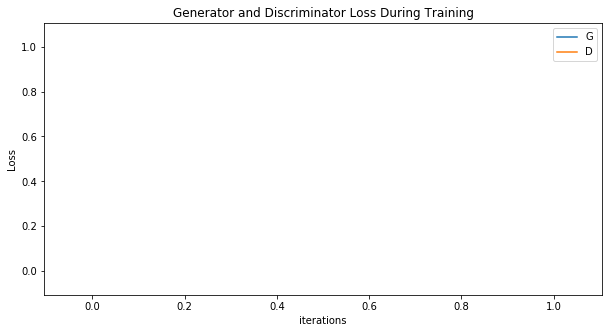

In [120]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
print('a')

a


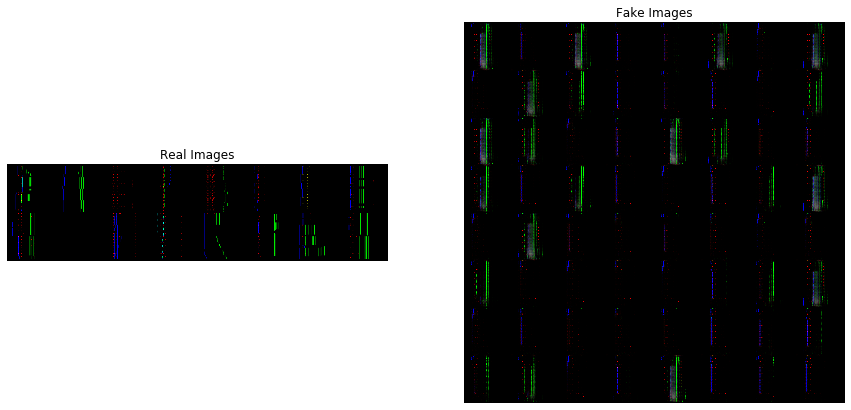

In [43]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
netG = Generator(ngpu).to(device)

In [14]:
PATH = './model/gen/Gen_downsample_layernorm_15948.pt'

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(PATH))
netG.eval()

Generator(
  (preprocess): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LayerNorm((256, 8, 8), eps=1e-05, elementwise_affine=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LayerNorm((64, 32, 32), eps=1e-05, elementwise_affine=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LayerNorm((32, 64, 64), eps=1e-05, elementwise_affine=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2

In [54]:
t_list = glob.glob('style_fake/*')

In [53]:
import glob

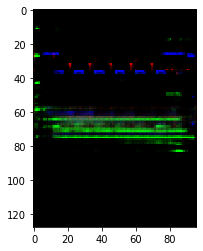

In [101]:
from PIL import Image
import cv2
img_num = 20
no_list = []
for i in range(img_num):
    noise = torch.randn(batch_size, nz, device=device)
    # noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
    fake = netG(noise)
    no_list.append(noise[0])
    img = fake[0].cpu().detach().numpy()
    img = vutils.make_grid(fake[0].cpu().detach(), padding=2, normalize=True)
    # img2 = cv2.transpose(img.T)
    img3 = cv2.resize(img.T.numpy(),(96,128))
    plt.imshow(img3)
    plt.imsave('output/fake'+str(i)+'.png', img3)
    # img4 = 255*img3
    # cv2.imwrite('haaha.png',img3)
    # np.max(img4)

In [95]:
np.linalg.norm(no_list[0].cpu().detach().numpy()-no_list[1].cpu().detach().numpy())

14.290654

In [97]:
fk1 = plt.imread('output/fake0.png')
fk2 = plt.imread('output/fake1.png')
np.linalg.norm(fk1-fk2)

13.402553

In [99]:
fk1

array([[[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.01176471, 0.        , 0.        , 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.      

tensor([3.4463, 3.5604, 4.1178, 3.2920, 5.2082, 3.5569, 5.5640, 4.8893, 4.0856,
        3.0107, 4.0405, 4.0191, 5.5903, 2.7987, 3.6066, 5.9915, 4.6488, 5.9294,
        2.9780, 4.6353, 5.7954, 5.8530, 3.8890, 3.7260, 4.0373, 5.1768, 2.5998,
        4.0516, 4.7694, 4.7518, 5.7388, 5.5917, 4.6036, 3.9727, 3.6530, 4.9424,
        4.2503, 4.7359, 4.6023, 4.4216, 4.3795, 4.1268, 4.9445, 3.9780, 4.7826,
        4.2102, 4.2430, 2.6810, 3.9807, 4.3227, 5.0360, 3.2384, 3.9358, 4.6393,
        4.6924, 2.9867, 4.7402, 5.6222, 5.2671, 4.7868, 4.6332, 4.5064, 4.0110,
        5.7508, 4.3417, 4.6883, 6.6595, 4.4270, 3.8005, 4.6389, 2.9033, 3.7291,
        4.7178, 4.3745, 3.7566, 3.2002, 4.7248, 4.1985, 5.0139, 2.7849, 7.3539,
        4.3941, 3.0136, 5.7917, 5.8534, 4.7636, 5.5583, 4.0451, 4.7220, 3.4318,
        3.9527, 5.6963, 3.6081, 5.3388, 4.6061, 5.5694, 2.1072, 2.1049, 5.7216,
        3.1553], device='cuda:0')


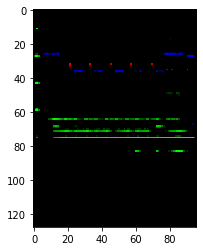

In [64]:
noise+=1
print(noise[0])
fake = netG(noise[0])
img = fake[0].cpu().detach().numpy()
img3 = cv2.resize(img.T,(96,128))
plt.imshow(img3)

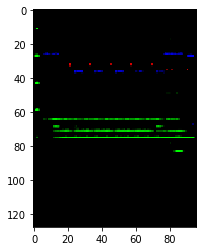

In [52]:
fake = netG(noise)
img = fake[0].cpu().detach().numpy()
img3 = cv2.resize(img.T,(96,128))
plt.imshow(img3)

# create midi

In [77]:
import glob
import os
from pypianoroll import *
import numpy as np
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import scipy.misc
import imageio

In [102]:
img_list = glob.glob('output/*')
sorted(img_list)
img_set = []
for img in img_list:
    temp = imageio.imread(img)
    print(temp.shape)
    
#     temp = np.transpose(temp,(1,0,2))
#     temp = cv2.resize(temp,(96,128))
#     temp = cv2.flip(temp,0)
    print(temp.shape)
    img_set.append(temp)
dd = np.hstack(img_set)
imageio.imsave('haha-13.png',dd)

cc = imageio.imread('haha-13.png')# cc = np.transpose(bbb,axes = (1,0,2))
cc[cc<255/(2)] =0
tst_trk = Multitrack()
tr1 = pypianoroll.Track(np.transpose(cc[:,:,0]),program=1, is_drum=False,name='drum')
tr2 = pypianoroll.Track(np.transpose(cc[:,:,1]),program=1, is_drum=False,name='piano')
tr3 = pypianoroll.Track(np.transpose(cc[:,:,2]),program=33, is_drum=False,name='base')
tst_trk.append_track(tr1)
tst_trk.append_track(tr2)
tst_trk.append_track(tr3)
tst_trk.remove_empty_tracks()
tst_trk.write('tre_outfile.mid')

(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)


In [132]:
from PIL import Image
from matplotlib import cm
plt.imsave('haha.png', img3)

In [124]:
img3

array([[[0.27920035, 0.2924108 , 0.33159596],
        [0.19735786, 0.17606811, 0.18511674],
        [0.14221789, 0.19227967, 0.130357  ],
        ...,
        [0.15214564, 0.19549276, 0.16718055],
        [0.17958081, 0.21072134, 0.16685526],
        [0.35718578, 0.34483948, 0.26414558]],

       [[0.17556357, 0.20478274, 0.20820826],
        [0.20693734, 0.20289564, 0.24408874],
        [0.18163465, 0.17886345, 0.19554749],
        ...,
        [0.17564452, 0.22684224, 0.20027322],
        [0.15939787, 0.22115877, 0.17836119],
        [0.2234014 , 0.24207121, 0.22639865]],

       [[0.18315238, 0.19346544, 0.14597903],
        [0.16039109, 0.18825597, 0.15122406],
        [0.16034678, 0.23092575, 0.16651022],
        ...,
        [0.18630897, 0.17261484, 0.15869181],
        [0.14530489, 0.20726648, 0.18301275],
        [0.23420645, 0.27773643, 0.23064215]],

       ...,

       [[0.19826089, 0.22226521, 0.20758502],
        [0.17563441, 0.19606599, 0.17243962],
        [0.18138267, 0

In [185]:
img_list[0].shape

torch.Size([3, 1042, 1042])

In [81]:
img2 = cv2.transpose(img.T)
img2[img2>255] =255
cv2.imwrite('haaha.png',cv2.resize(img2,(100,106)))
plt.imshow(cv2.resize(img2,(100,106)))

TypeError: Expected Ptr<cv::UMat> for argument 'src'

0.18260498

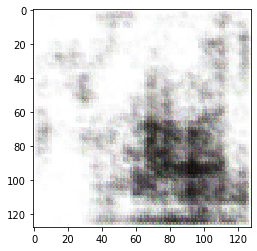

In [87]:
fake = netG(noise)
img = fake[0].cpu().detach().numpy()
plt.imshow(1-img.T)
np.average(img)

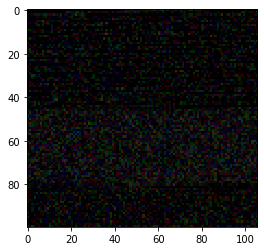

In [199]:
a = img[img<0.2].T
b = np.resize(a,(100,106,3))
# cv2.imwrite('haha.png',b)
plt.imshow(b)

In [ ]:
len(img_list)

In [ ]:
plt.imshow(b)

In [ ]:
import tflib

In [ ]:
import os, sys
sys.path.append(os.getcwd())

import time
import tflib as lib
import tflib.save_images
import tflib.mnist
import tflib.cifar10
import tflib.plot
import tflib.inception_score

import numpy as np


import torch
import torchvision
from torch import nn
from torch import autograd
from torch import optim

# Download CIFAR-10 (Python version) at
# https://www.cs.toronto.edu/~kriz/cifar.html and fill in the path to the
# extracted files here!
DATA_DIR = 'data/'
if len(DATA_DIR) == 0:
    raise Exception('Please specify path to data directory in gan_cifar.py!')

MODE = 'wgan-gp' # Valid options are dcgan, wgan, or wgan-gp
DIM = 128 # This overfits substantially; you're probably better off with 64
LAMBDA = 10 # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5 # How many critic iterations per generator iteration
BATCH_SIZE = 64 # Batch size
ITERS = 200000 # How many generator iterations to train for
OUTPUT_DIM = 3072 # Number of pixels in CIFAR10 (3*32*32)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        preprocess = nn.Sequential(
            nn.Linear(128, 4 * 4 * 4 * DIM),
            nn.BatchNorm2d(4 * 4 * 4 * DIM),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * DIM, 2 * DIM, 2, stride=2),
            nn.BatchNorm2d(2 * DIM),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * DIM, DIM, 2, stride=2),
            nn.BatchNorm2d(DIM),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(DIM, 3, 2, stride=2)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * DIM, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, 3, 32, 32)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        main = nn.Sequential(
            nn.Conv2d(3, DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(DIM, 2 * DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * DIM, 4 * DIM, 3, 2, padding=1),
            nn.LeakyReLU(),
        )

        self.main = main
        self.linear = nn.Linear(4*4*4*DIM, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*DIM)
        output = self.linear(output)
        return output

netG = Generator()
netD = Discriminator()
print (netG)
print (netD)

use_cuda = torch.cuda.is_available()
if use_cuda:
    gpu = 0
if use_cuda:
    netD = netD.cuda(gpu)
    netG = netG.cuda(gpu)

one = torch.FloatTensor([1])
mone = one * -1
if use_cuda:
    one = one.cuda(gpu)
    mone = mone.cuda(gpu)

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

def calc_gradient_penalty(netD, real_data, fake_data):
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, real_data.nelement()/BATCH_SIZE).contiguous().view(BATCH_SIZE, 3, 32, 32)
    alpha = alpha.cuda(gpu) if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda(gpu)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(gpu) if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# For generating samples
def generate_image(frame, netG):
    fixed_noise_128 = torch.randn(128, 128)
    if use_cuda:
        fixed_noise_128 = fixed_noise_128.cuda(gpu)
    noisev = autograd.Variable(fixed_noise_128, volatile=True)
    samples = netG(noisev)
    samples = samples.view(-1, 3, 32, 32)
    samples = samples.mul(0.5).add(0.5)
    samples = samples.cpu().data.numpy()

    lib.save_images.save_images(samples, './tmp/cifar10/samples_{}.jpg'.format(frame))

# For calculating inception score
def get_inception_score(G, ):
    all_samples = []
    for i in xrange(10):
        samples_100 = torch.randn(100, 128)
        if use_cuda:
            samples_100 = samples_100.cuda(gpu)
        samples_100 = autograd.Variable(samples_100, volatile=True)
        all_samples.append(G(samples_100).cpu().data.numpy())

    all_samples = np.concatenate(all_samples, axis=0)
    all_samples = np.multiply(np.add(np.multiply(all_samples, 0.5), 0.5), 255).astype('int32')
    all_samples = all_samples.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    return lib.inception_score.get_inception_score(list(all_samples))

# Dataset iterator
train_gen, dev_gen = lib.cifar10.load(BATCH_SIZE, data_dir=DATA_DIR)
def inf_train_gen():
    while True:
        for images, target in train_gen():
            # yield images.astype('float32').reshape(BATCH_SIZE, 3, 32, 32).transpose(0, 2, 3, 1)
            yield images
gen = inf_train_gen()
preprocess = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

for iteration in xrange(ITERS):
    start_time = time.time()
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for i in xrange(CRITIC_ITERS):
        _data = gen.next()
        netD.zero_grad()

        # train with real
        _data = _data.reshape(BATCH_SIZE, 3, 32, 32).transpose(0, 2, 3, 1)
        real_data = torch.stack([preprocess(item) for item in _data])

        if use_cuda:
            real_data = real_data.cuda(gpu)
        real_data_v = autograd.Variable(real_data)

        # import torchvision
        # filename = os.path.join("test_train_data", str(iteration) + str(i) + ".jpg")
        # torchvision.utils.save_image(real_data, filename)

        D_real = netD(real_data_v)
        D_real = D_real.mean()
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(BATCH_SIZE, 128)
        if use_cuda:
            noise = noise.cuda(gpu)
        noisev = autograd.Variable(noise, volatile=True)  # totally freeze netG
        fake = autograd.Variable(netG(noisev).data)
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        # print "gradien_penalty: ", gradient_penalty

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()
    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    noise = torch.randn(BATCH_SIZE, 128)
    if use_cuda:
        noise = noise.cuda(gpu)
    noisev = autograd.Variable(noise)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()

    # Write logs and save samples
    lib.plot.plot('./tmp/cifar10/train disc cost', D_cost.cpu().data.numpy())
    lib.plot.plot('./tmp/cifar10/time', time.time() - start_time)
    lib.plot.plot('./tmp/cifar10/train gen cost', G_cost.cpu().data.numpy())
    lib.plot.plot('./tmp/cifar10/wasserstein distance', Wasserstein_D.cpu().data.numpy())

    # Calculate inception score every 1K iters
    if False and iteration % 1000 == 999:
        inception_score = get_inception_score(netG)
        lib.plot.plot('./tmp/cifar10/inception score', inception_score[0])

    # Calculate dev loss and generate samples every 100 iters
    if iteration % 100 == 99:
        dev_disc_costs = []
        for images, _ in dev_gen():
            images = images.reshape(BATCH_SIZE, 3, 32, 32).transpose(0, 2, 3, 1)
            imgs = torch.stack([preprocess(item) for item in images])

            # imgs = preprocess(images)
            if use_cuda:
                imgs = imgs.cuda(gpu)
            imgs_v = autograd.Variable(imgs, volatile=True)

            D = netD(imgs_v)
            _dev_disc_cost = -D.mean().cpu().data.numpy()
            dev_disc_costs.append(_dev_disc_cost)
        lib.plot.plot('./tmp/cifar10/dev disc cost', np.mean(dev_disc_costs))

        generate_image(iteration, netG)

    # Save logs every 100 iters
    if (iteration < 5) or (iteration % 100 == 99):
        lib.plot.flush()
    lib.plot.tick()

# WGAN + GP